In [ ]:
pwd

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [3]:
import numpy as np
import pandas as pd 
import pickle
from helper_funcs import *
from umap import UMAP

from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
data_dir = '../Data/latent_vecs/'
files = [file for file in os.listdir(data_dir) if file.startswith('latent')]
files.sort()
files

['latent_vecs_CVAE_2021-09-15 14:03:53.826090',
 'latent_vecs_CVAE_2021-09-30 17:08:46.471890']

In [5]:
weights = os.listdir('../Assets/tf_weights/')
weights.sort()
weights

['.ipynb_checkpoints',
 'CVAE_2021-09-15 07:07:52.059178',
 'CVAE_2021-09-15 07:16:36.484543',
 'CVAE_2021-09-15 07:19:23.138115',
 'CVAE_2021-09-15 14:03:53.826090',
 'CVAE_2021-09-16 16:34:00.330135',
 'CVAE_2021-09-30 15:00:00.089858',
 'CVAE_2021-09-30 15:41:40.385003',
 'CVAE_2021-09-30 17:08:46.471890',
 'CVAE_2021-10-01 08:19:19.567960',
 'CVAE_2021-10-05 16:12:30.839342',
 'CVAE_2021-10-06 08:06:32.222665',
 'CVAE_2021-10-06 08:08:11.612788',
 'CVAE_2021-10-06 08:35:55.310173',
 'CVAE_2021-10-06 09:18:26.408246',
 'CVAE_2021-10-06 09:19:00.166747']

In [6]:
weights_folder = 'CVAE_2021-10-06 08:35:55.310173'

In [7]:
from importlib import reload
import make_models;reload(make_models);from make_models import *

batch_size = 32
cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_4D(input_shape=(32,32,32,51),
                                                             latent_dim=16,
                                                             beta=1,
                                                             gamma=1,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = 3,
                                                             filters = 8,
                                                             intermediate_dim = 128,
                                                             nlayers = 5,
                                                             learning_rate=0.001,
                                                             opt=None)

In [8]:
cvae.load_weights(os.path.join('../Assets/tf_weights/',weights_folder,'cvae_weights'));

In [9]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df.head()

,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,...,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site
0,50002,1,1.0,16.77,1,Ambi,NaN,103.0,116.0,89.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050002,13
1,50003,1,1.0,24.45,1,R,NaN,124.0,128.0,115.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050003,13
2,50004,1,1.0,19.09,1,R,NaN,113.0,108.0,117.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050004,13
3,50005,1,1.0,13.73,2,R,NaN,119.0,117.0,118.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050005,13
4,50006,1,1.0,13.37,1,L,NaN,109.0,99.0,119.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-Pitt0050006,13


In [10]:
patients = df['DX_GROUP'].values==1

In [11]:
data_dir = '../Assets/fc_mats_32smooth_new'
s = 0
sub = df['bids_folder'].values[s]
datum = np.load(os.path.join(data_dir,sub+'.npy'))/2

In [12]:
from tqdm import tqdm
data = np.array([np.load(os.path.join(data_dir,sub+'.npy'))/2 for sub in tqdm(df['bids_folder'].values)])

100%|██████████| 1048/1048 [00:12<00:00, 86.30it/s]


In [13]:
data.shape

(1048, 32, 32, 32, 51)

In [14]:

datum = datum[np.newaxis,:,:,:,:]
datum.shape

(1, 32, 32, 32, 51)

In [15]:
def cvae_pred(datum,is_asd=False):
    
    if datum.ndim!=5:
        datum = datum[np.newaxis,:,:,:,:]
        
    z_vec = z_encoder.predict(datum)[2]
    s_vec = s_encoder.predict(datum)[2]
    zeros_ = np.zeros(s_vec.shape)

    is_asd = True

    if is_asd==True:
        vec = np.hstack((z_vec,s_vec))
    else:
        vec = np.hstack((z_vec,zeros_))


    pred = cvae_decoder.predict(vec)
    
    return pred

In [16]:
predictions = np.concatenate([cvae_pred(data[i,:,:,:,:],patients[i]) for i in tqdm(range(data.shape[0]))],axis=0)

100%|██████████| 1048/1048 [01:25<00:00, 12.29it/s]


In [17]:
predictions.shape

(1048, 32, 32, 32, 51)

In [18]:
import ants
temp = ants.image_read('../Assets/fc_maps_32smooth/sub-Caltech0051456.nii')

In [19]:
im = temp.new_image_like(predictions.mean(axis=0))

In [20]:
r_df = pd.read_csv('../Data/YeoAtlas/Yeo2011_7Networks_N1000.split_components.FSL_MNI152_2mm.Centroid_RAS.csv')
rlbls = r_df['Label Name'].values[1::]

<ipython-input-21-130e2fe76e24>:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



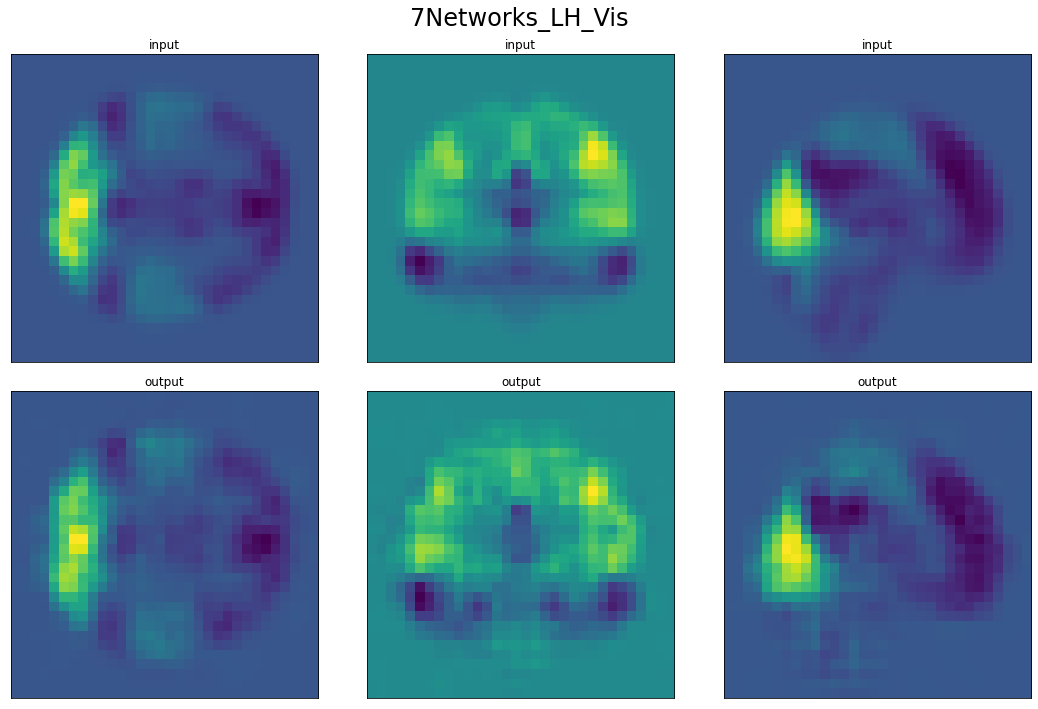

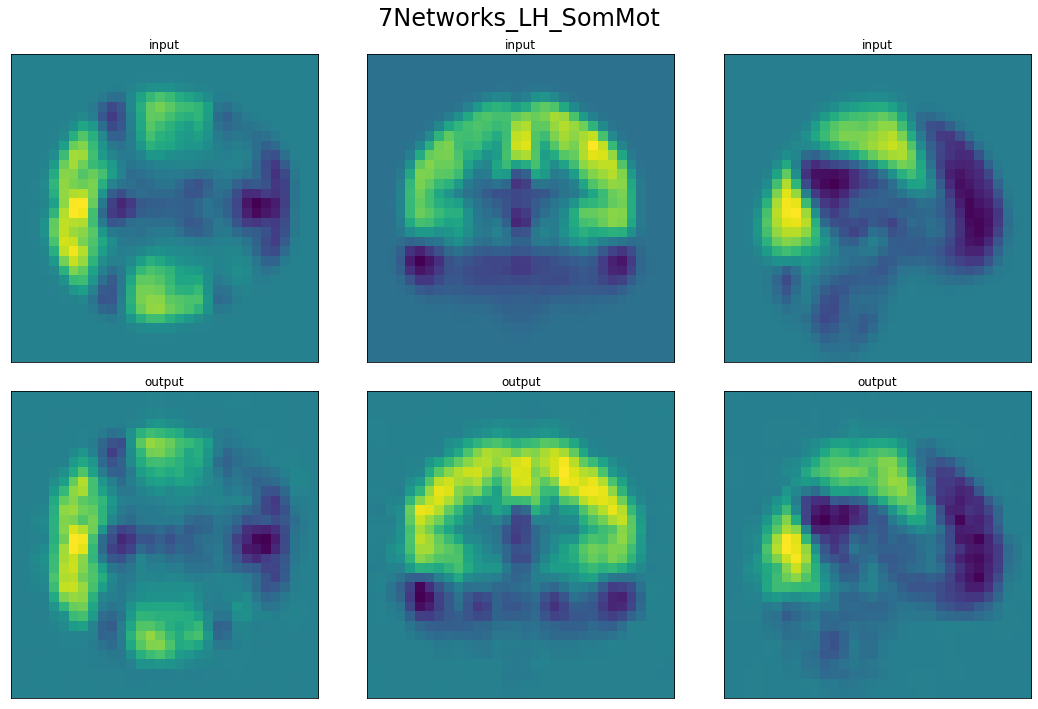

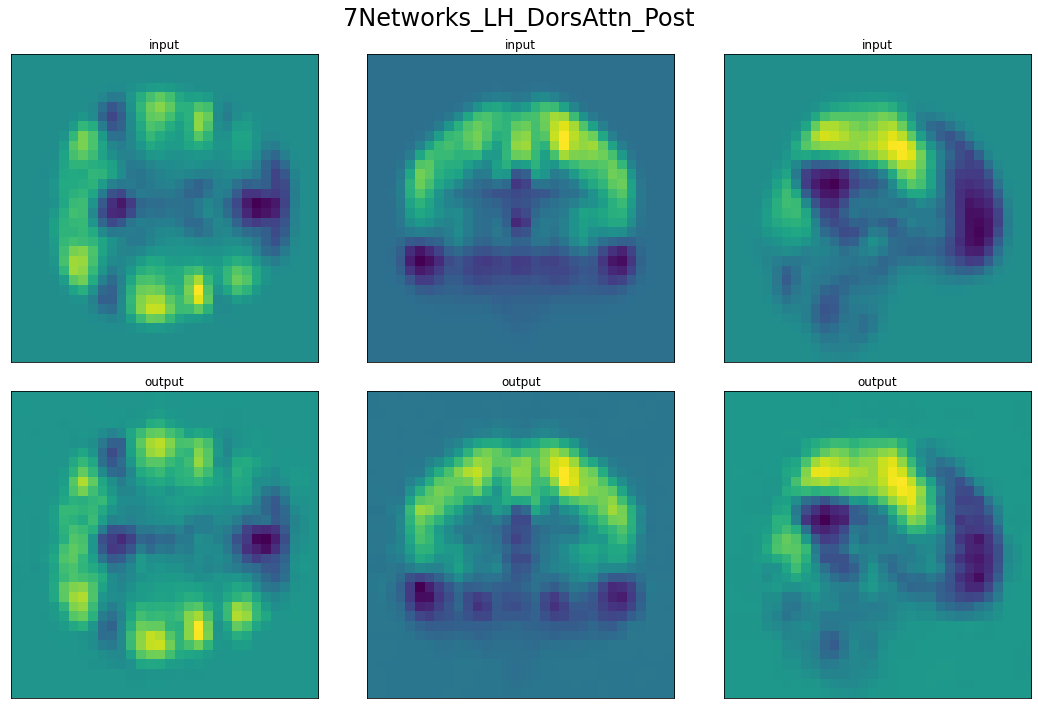

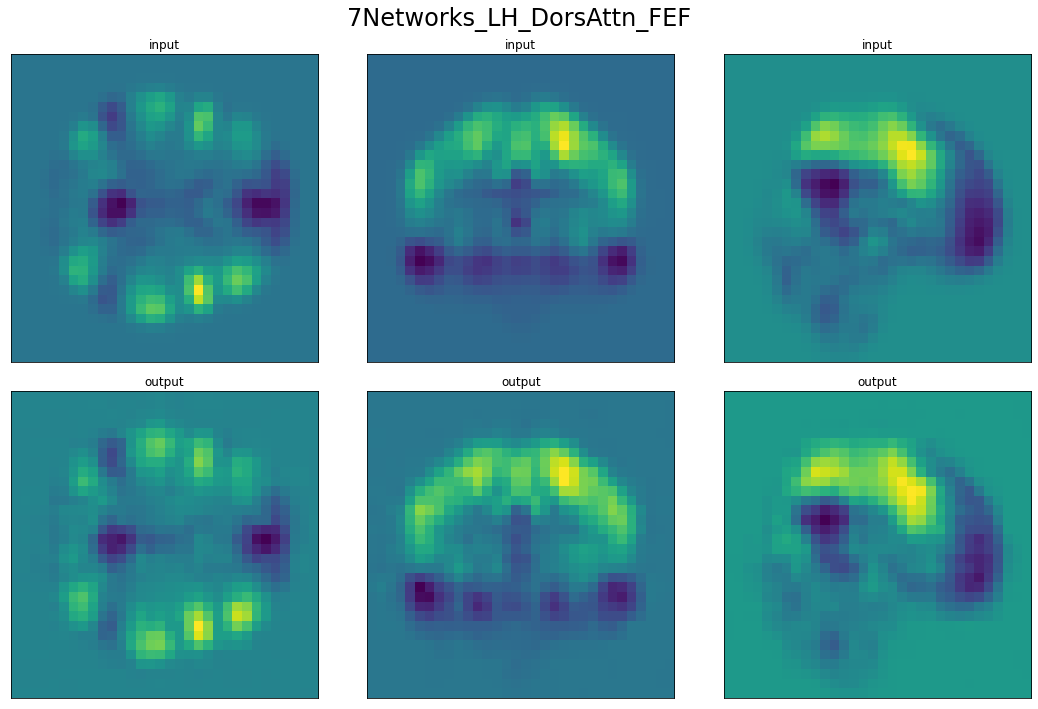

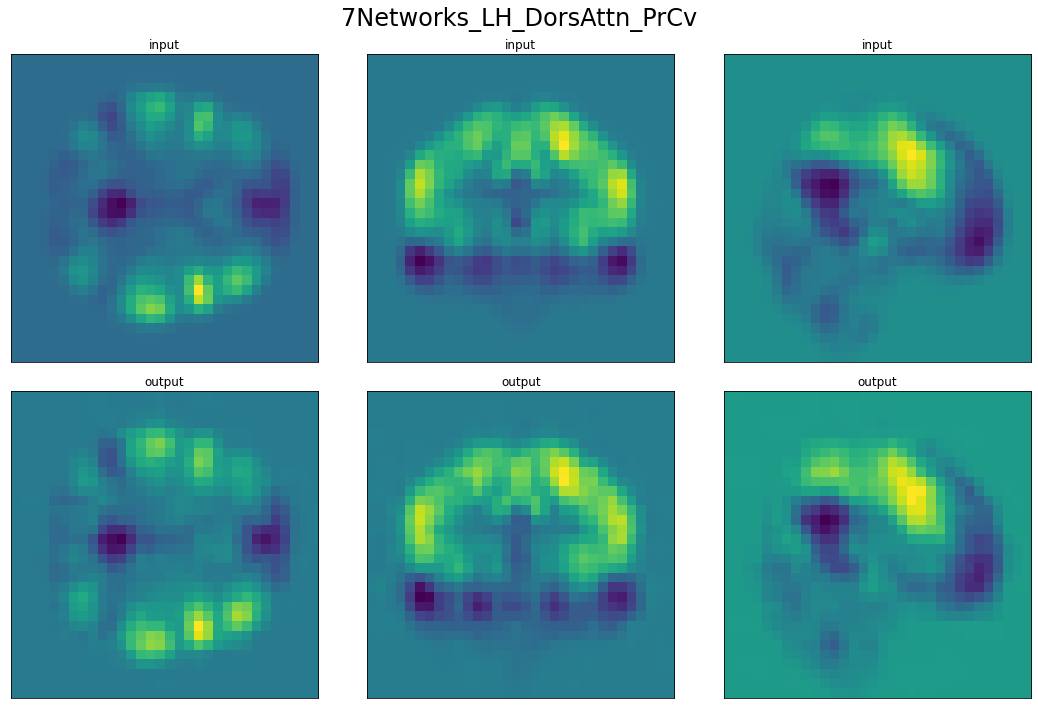

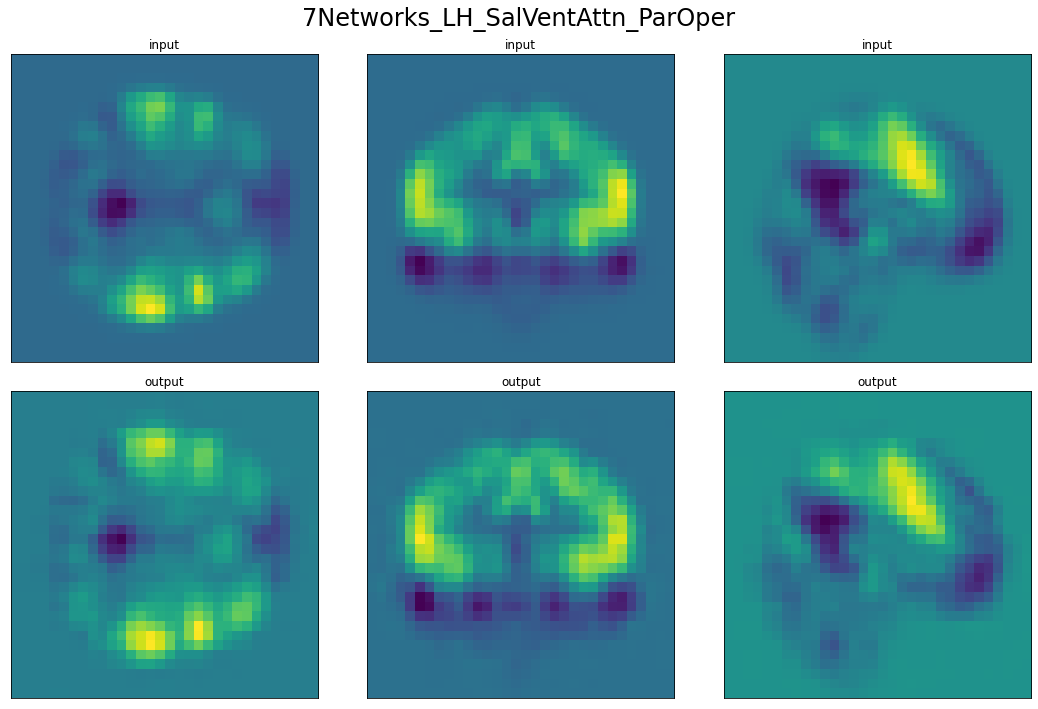

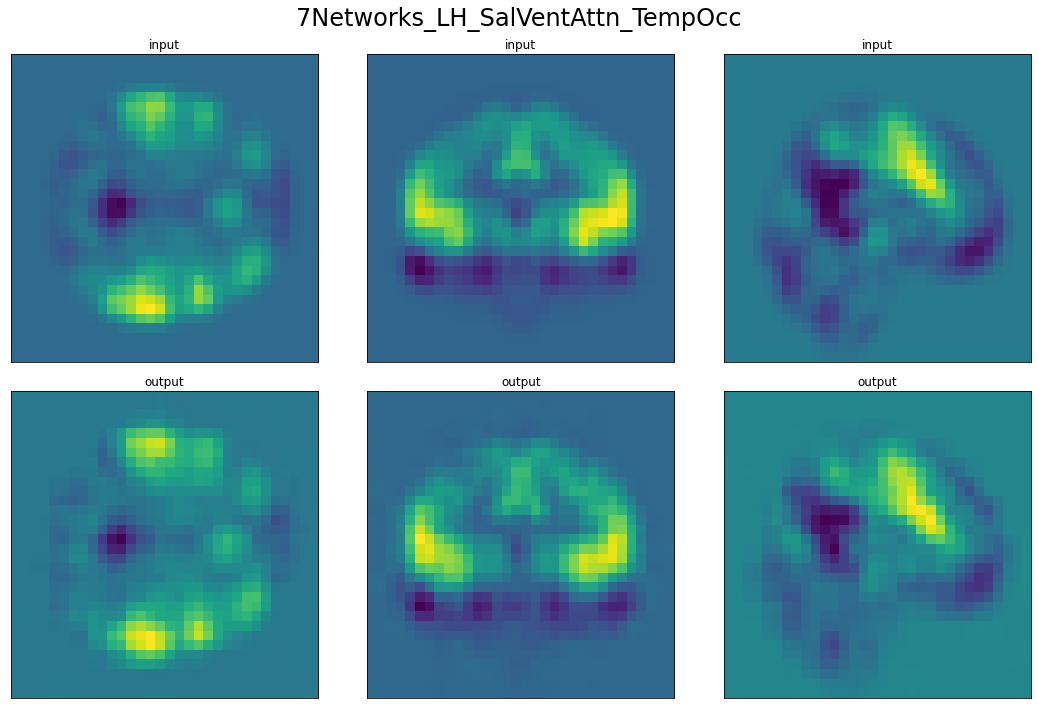

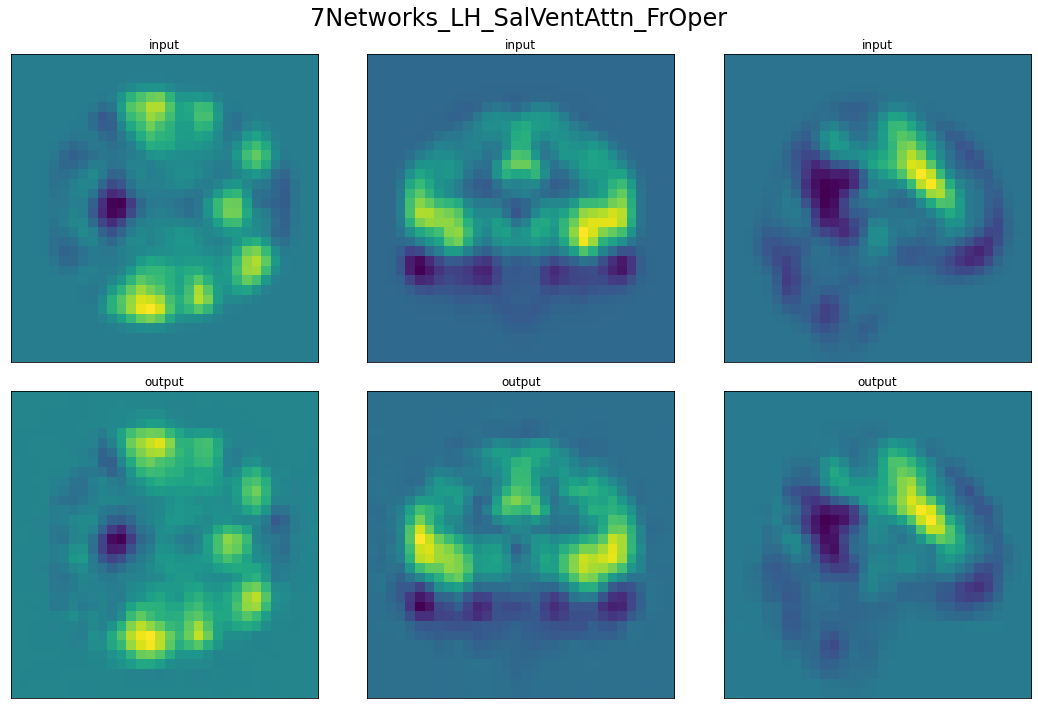

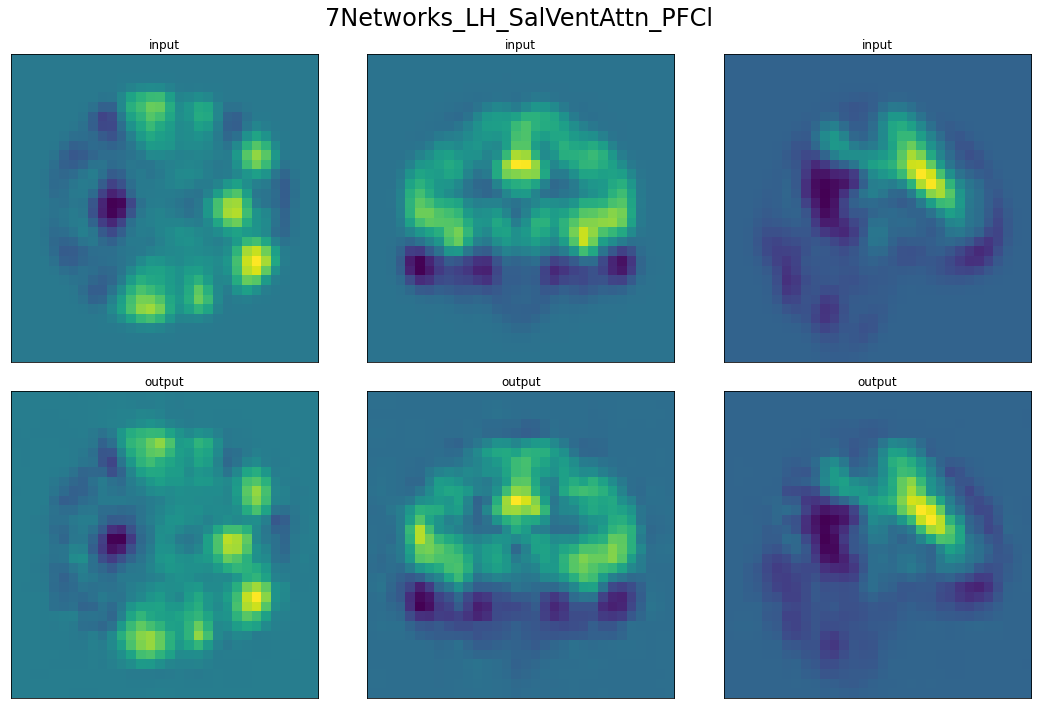

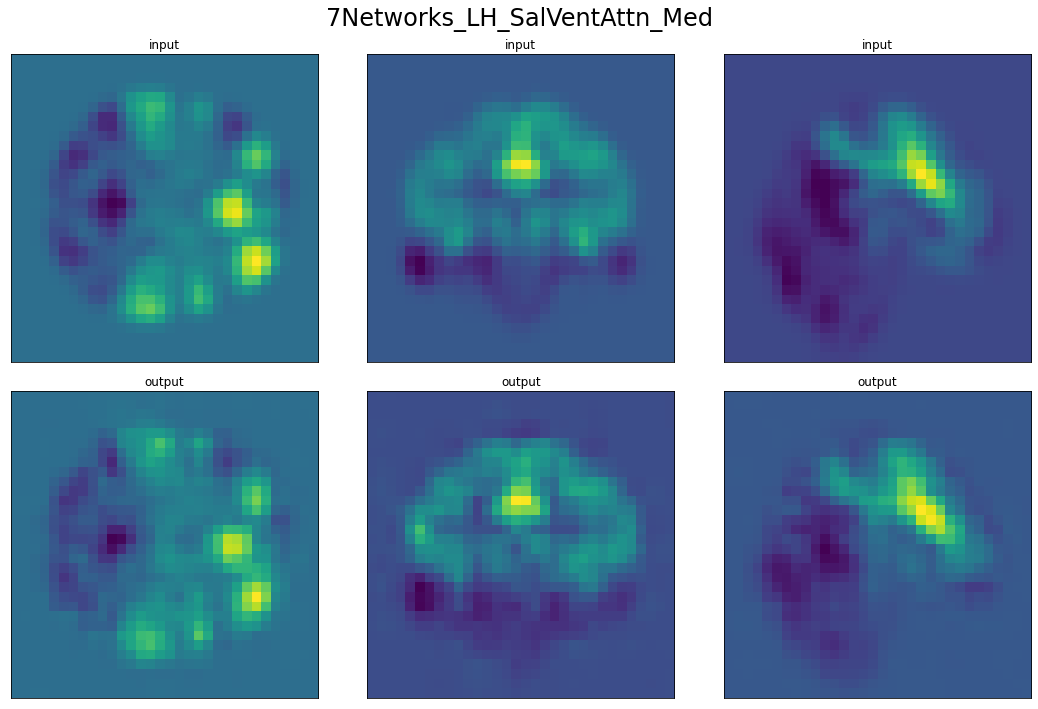

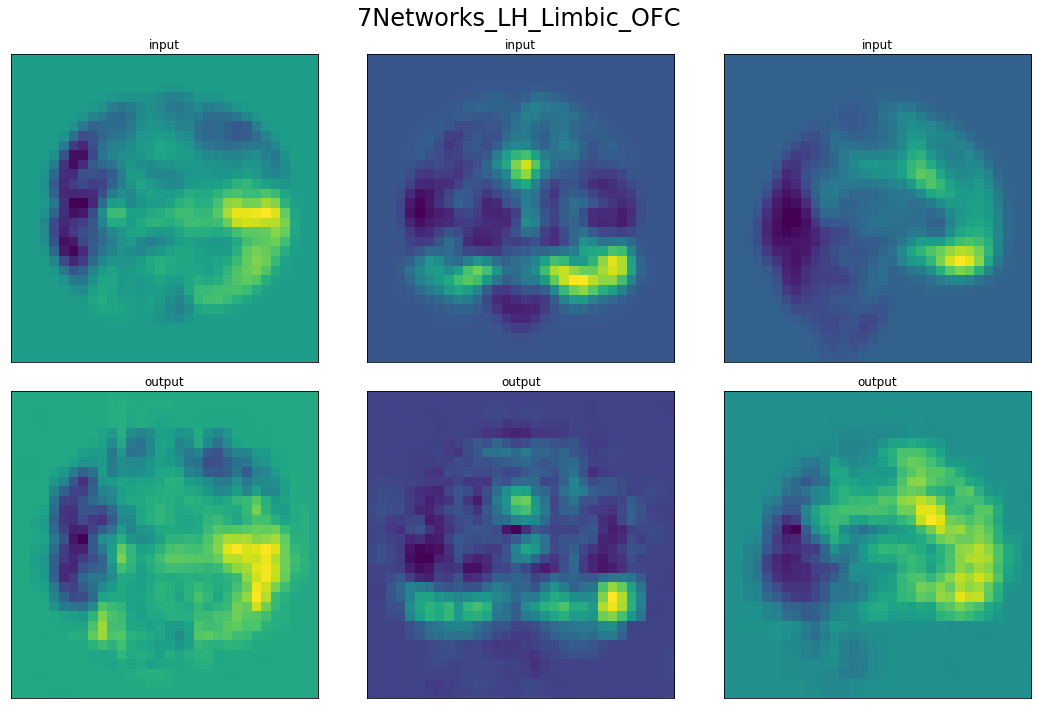

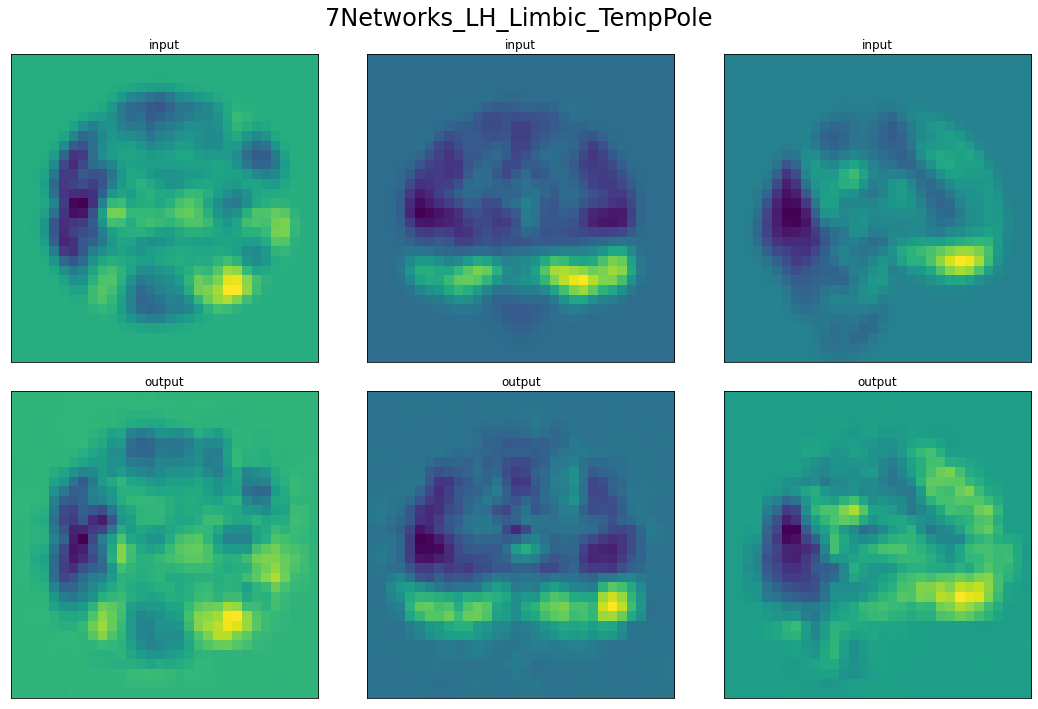

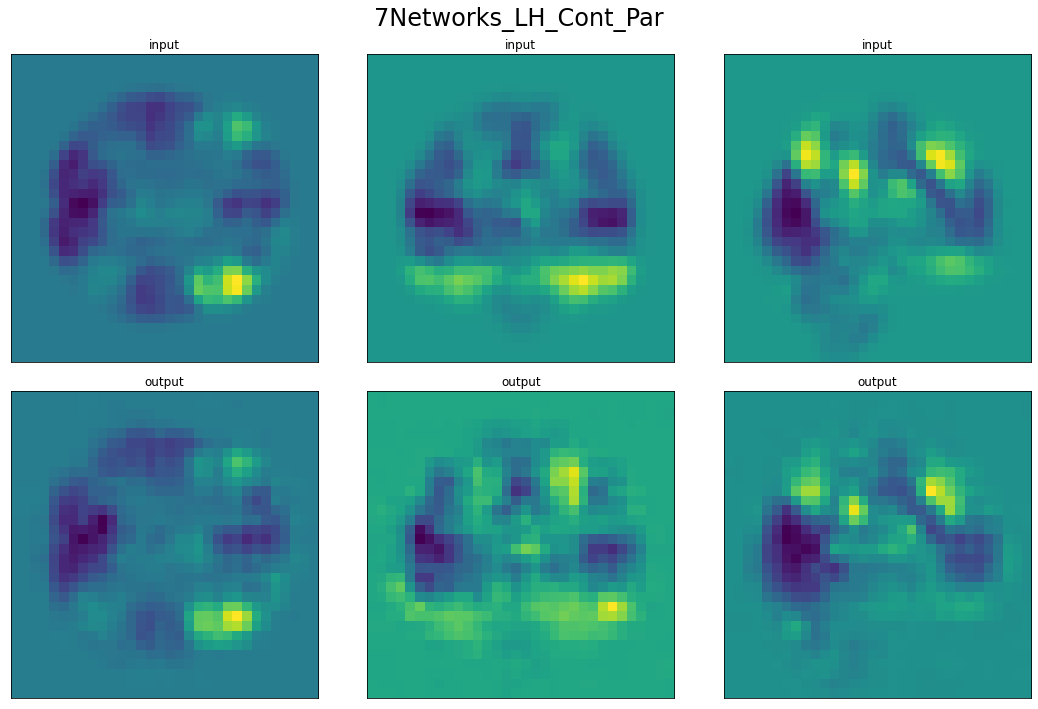

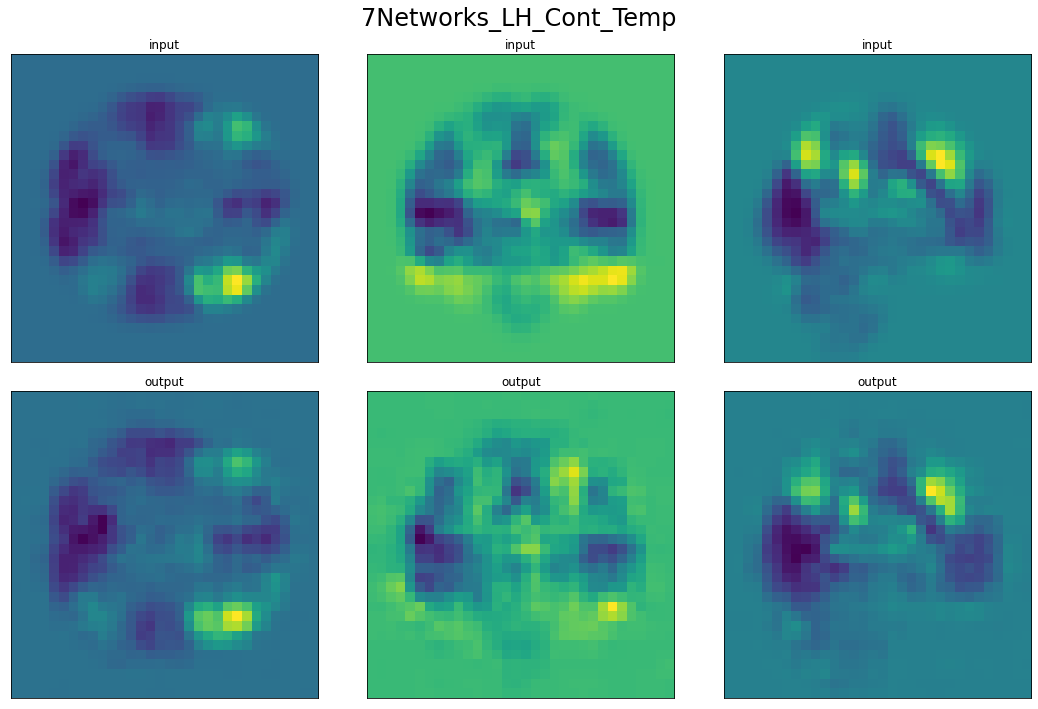

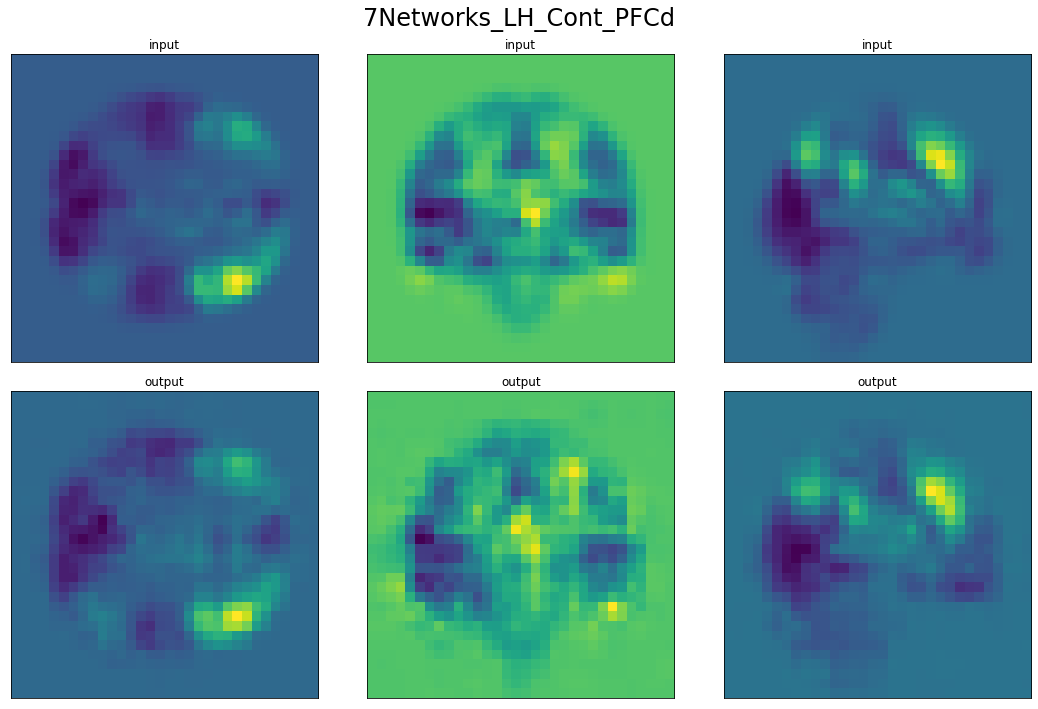

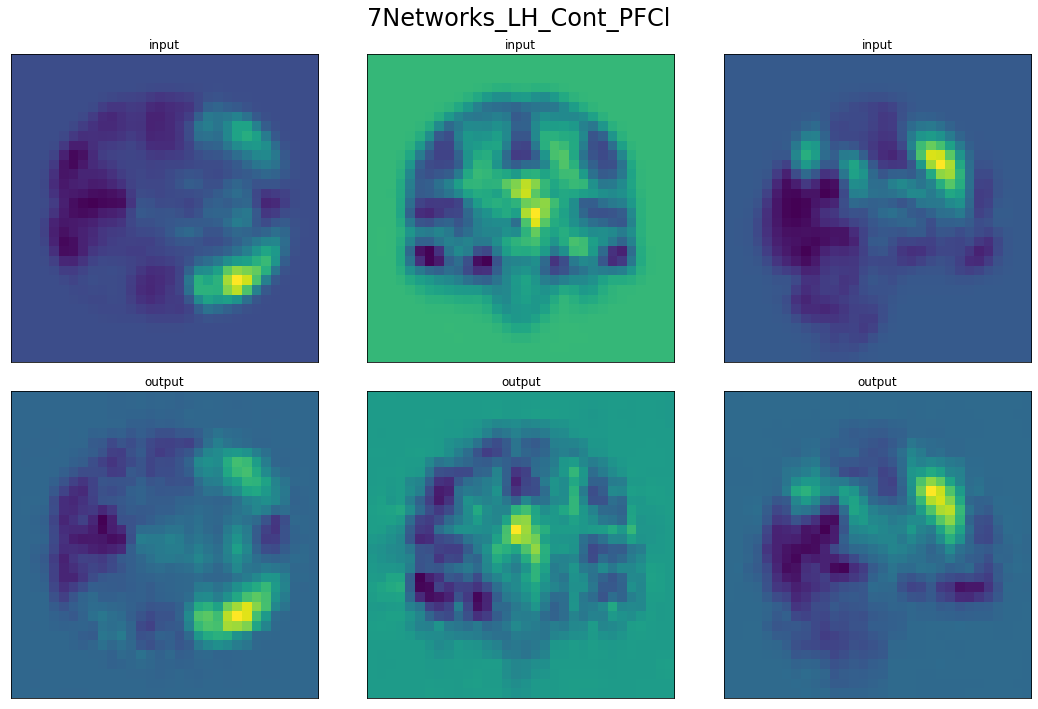

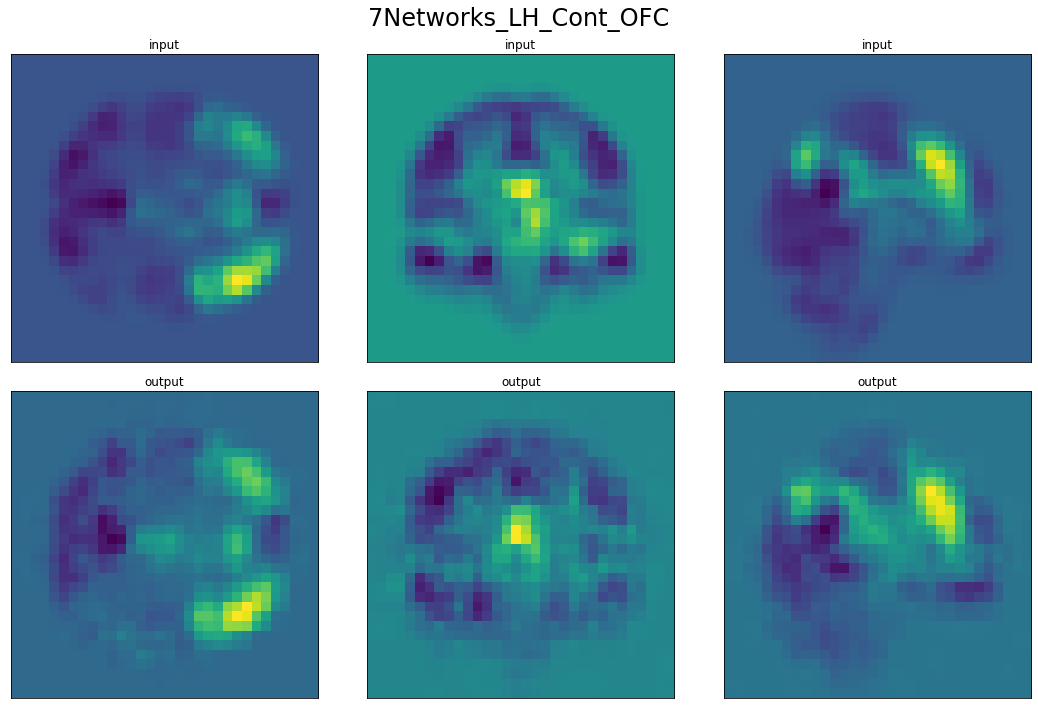

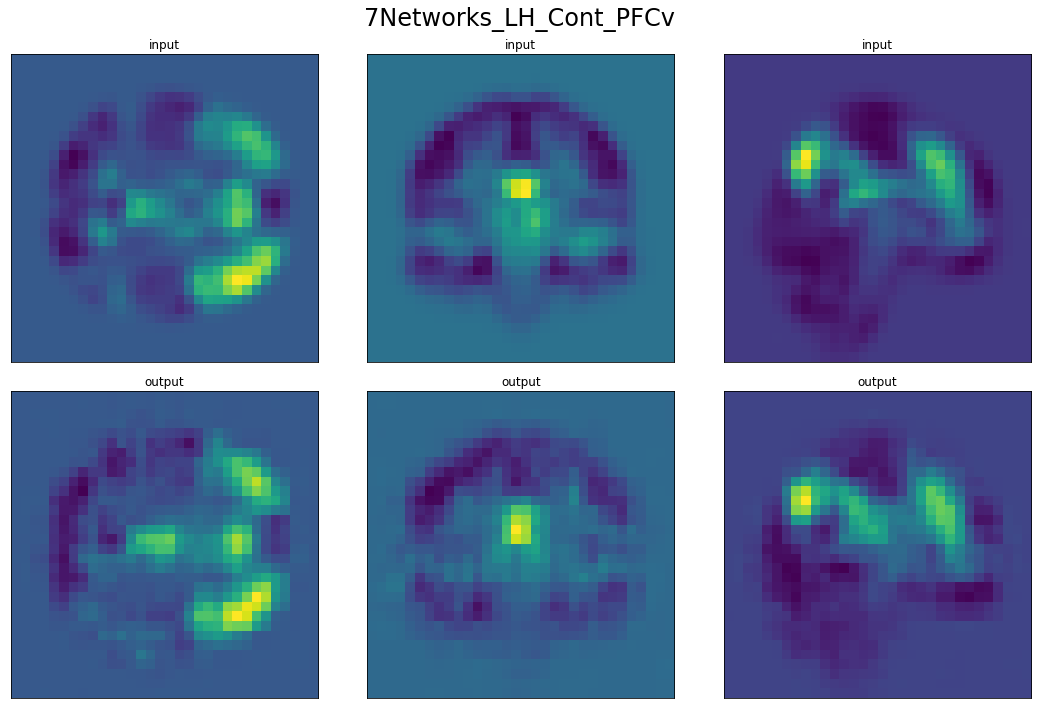

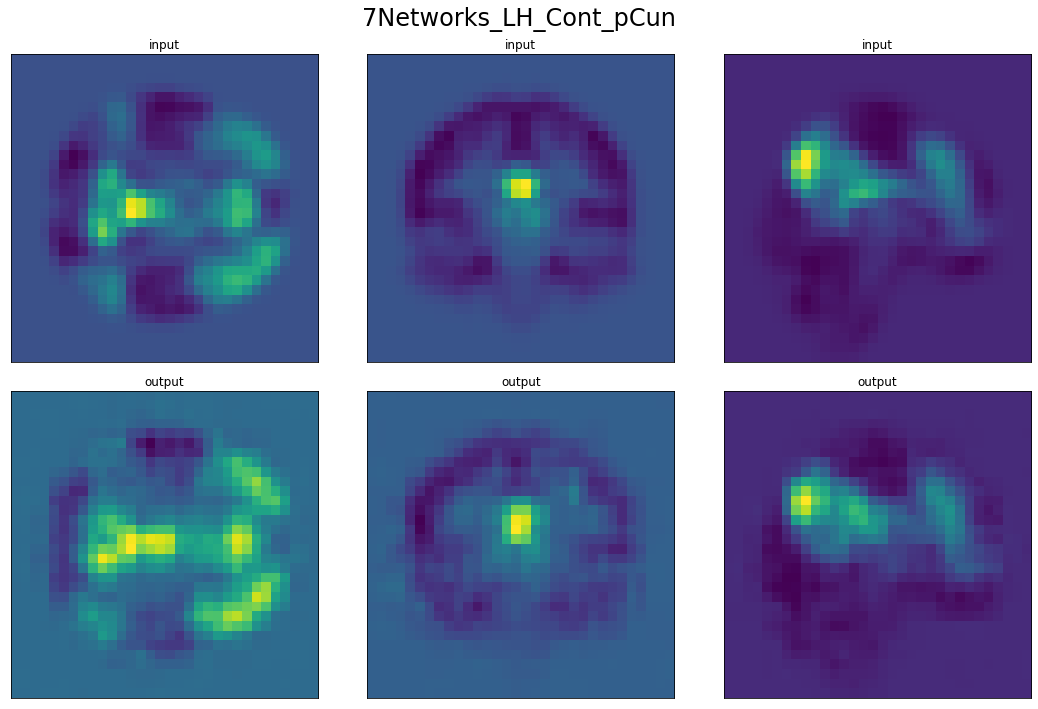

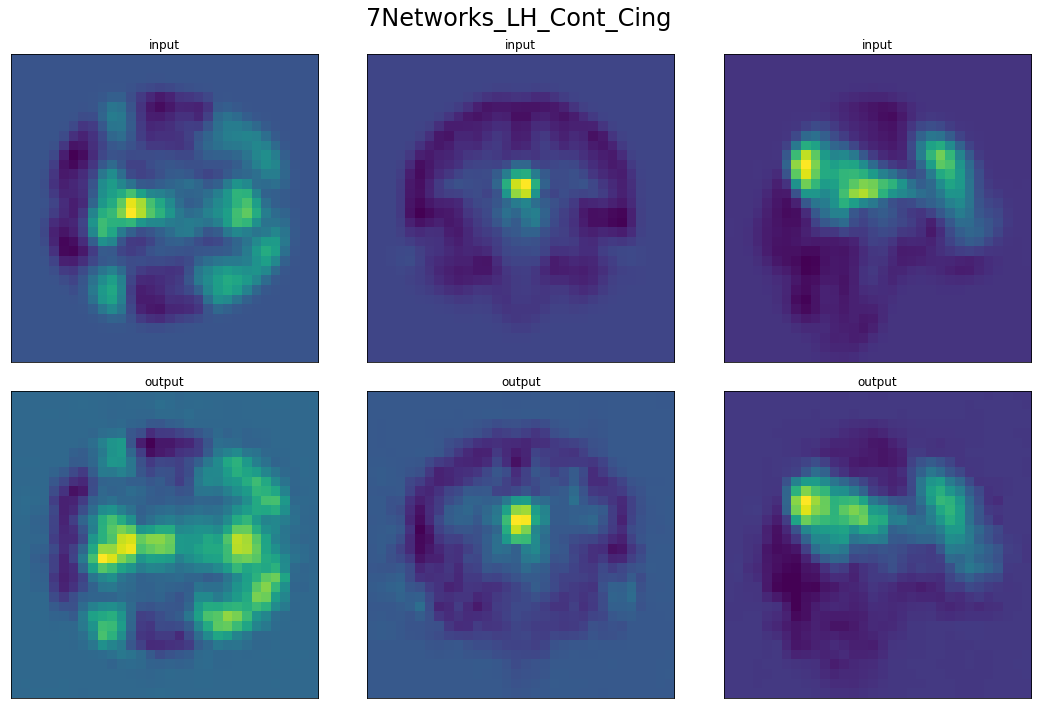

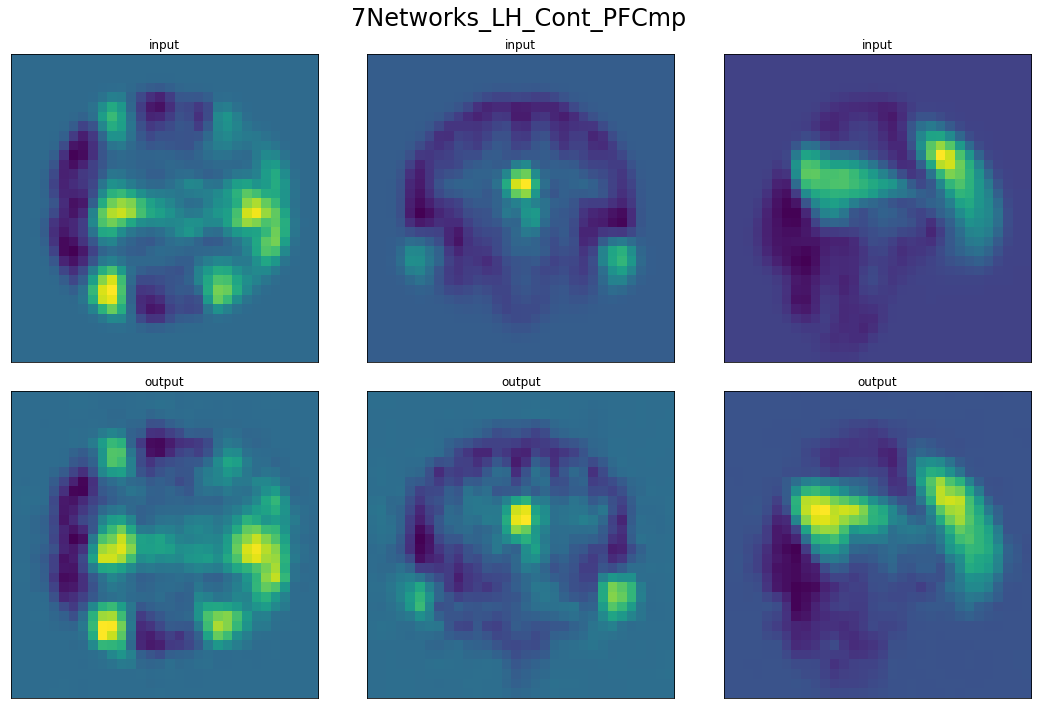

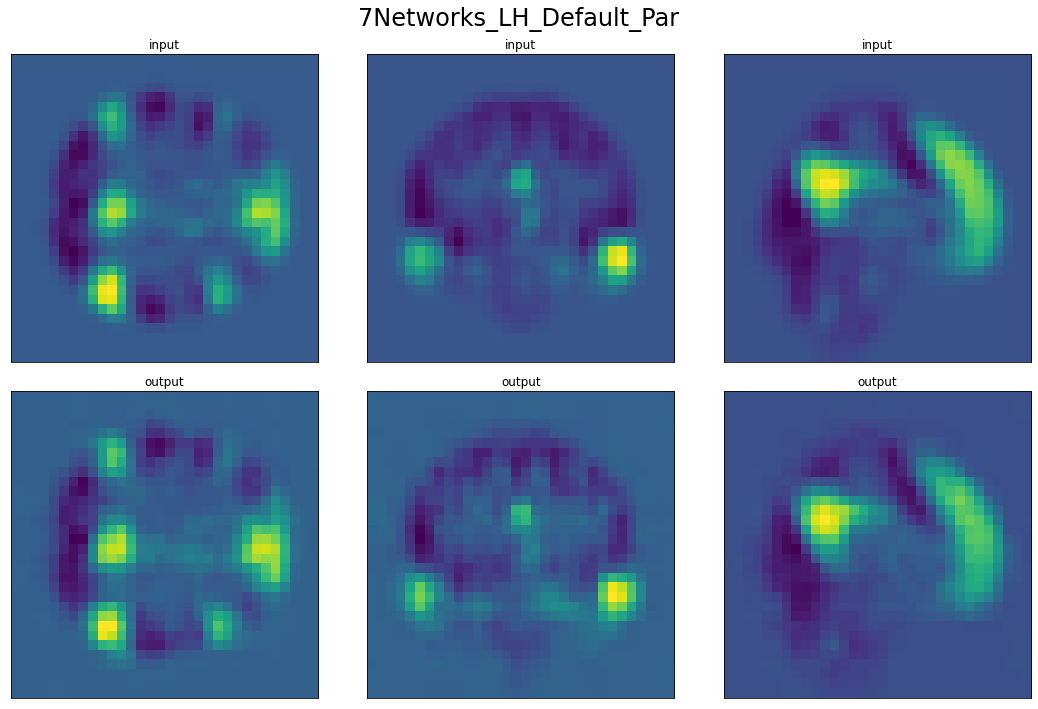

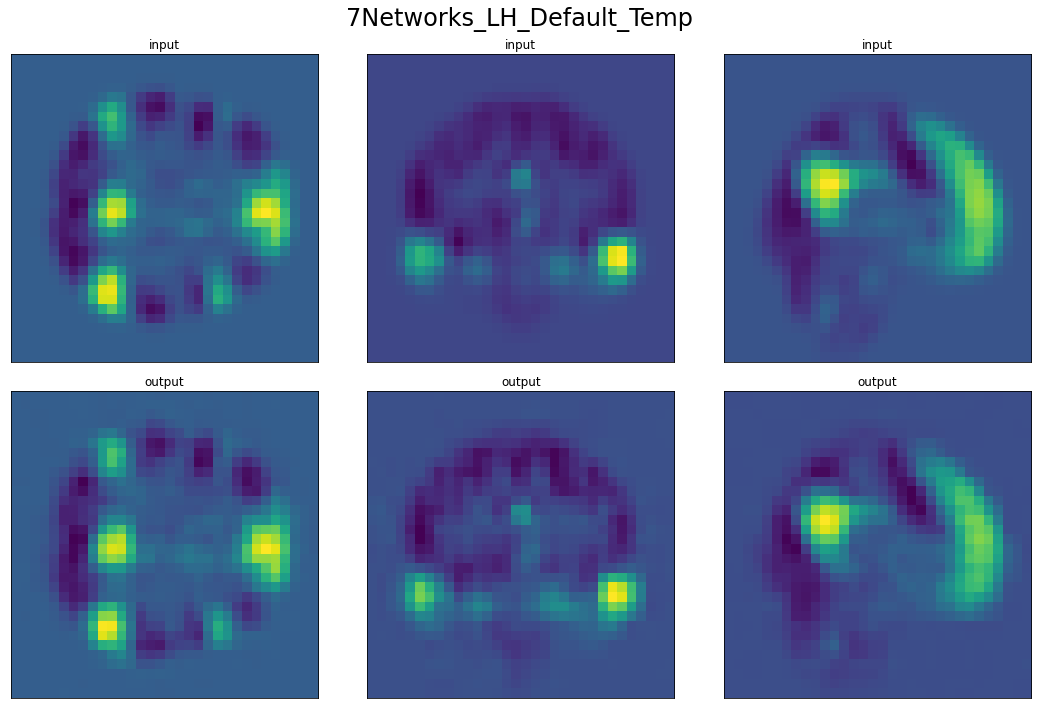

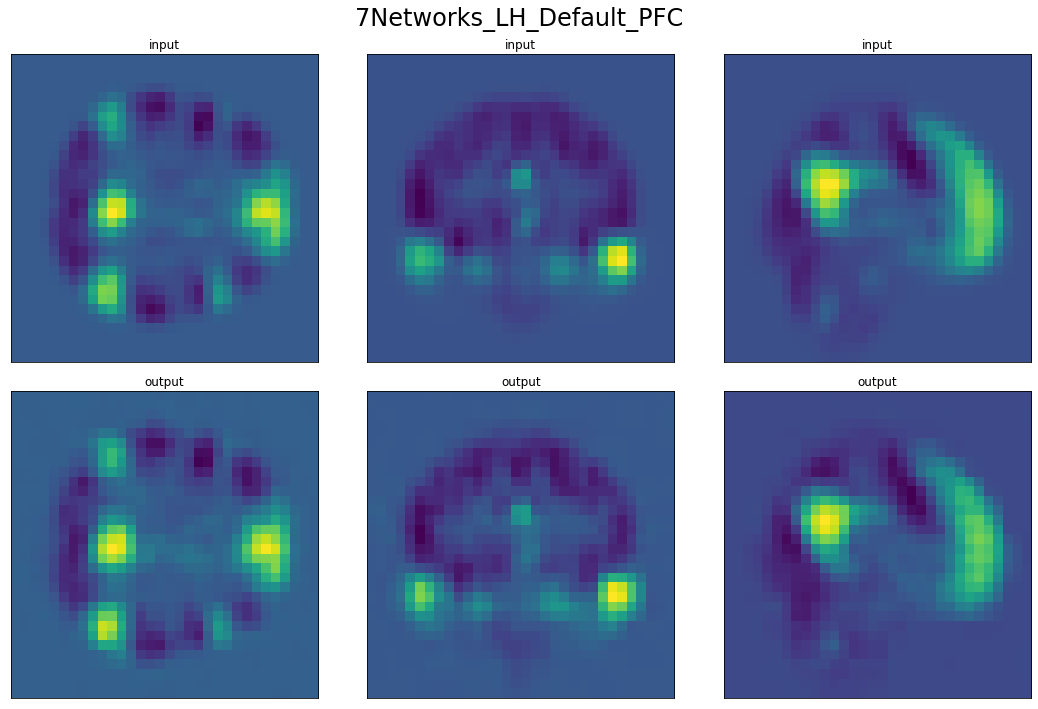

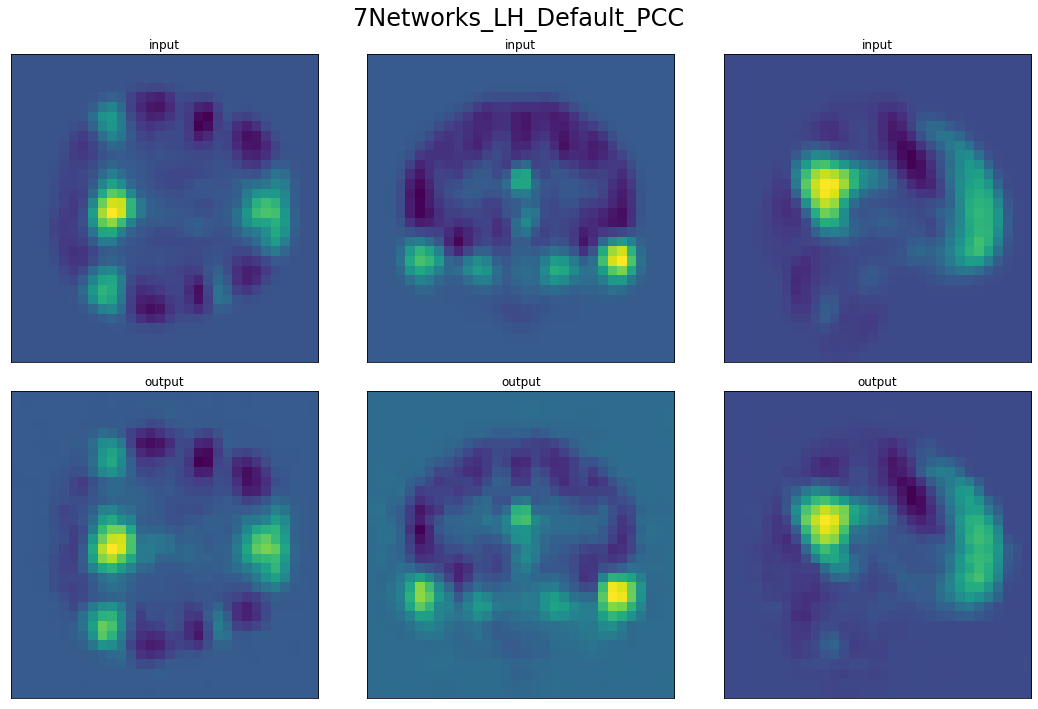

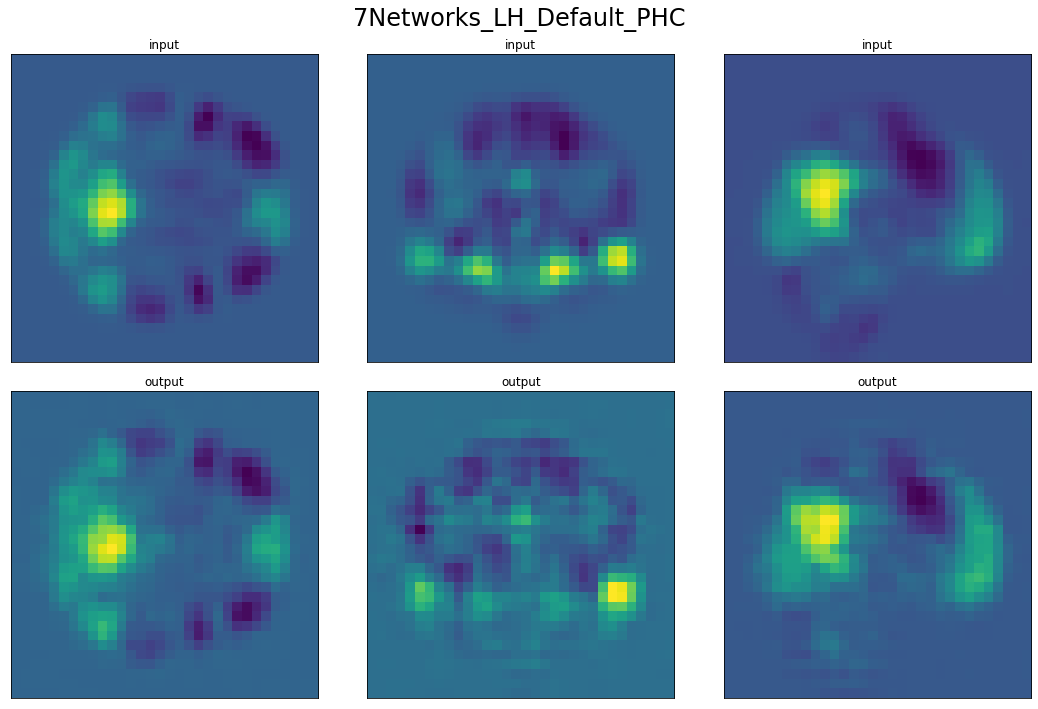

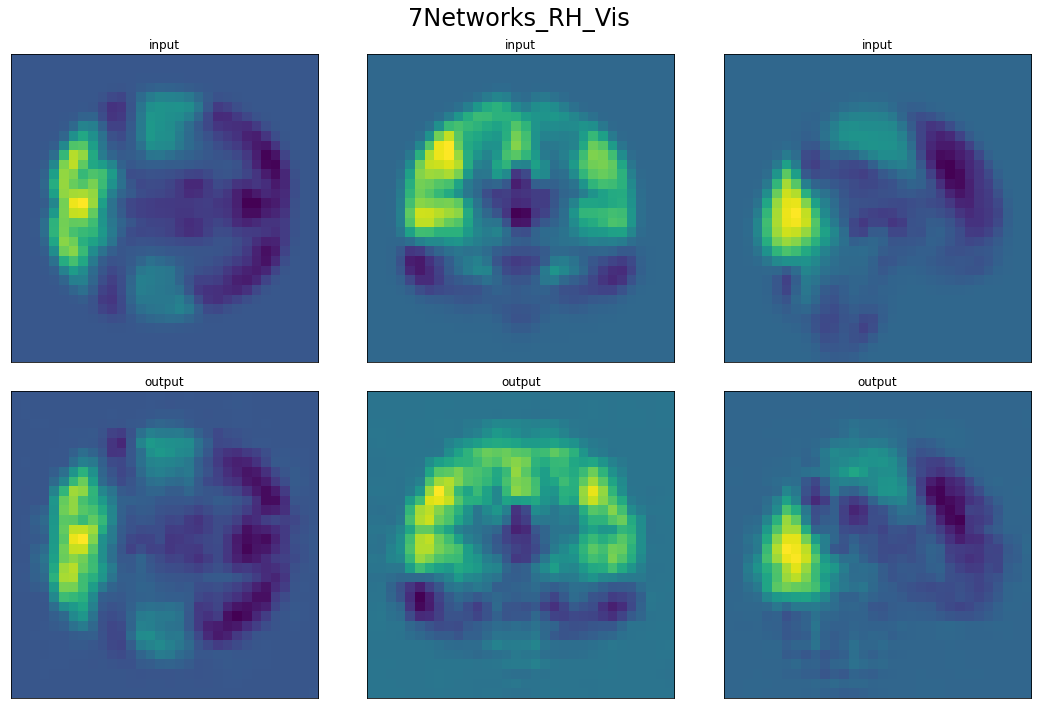

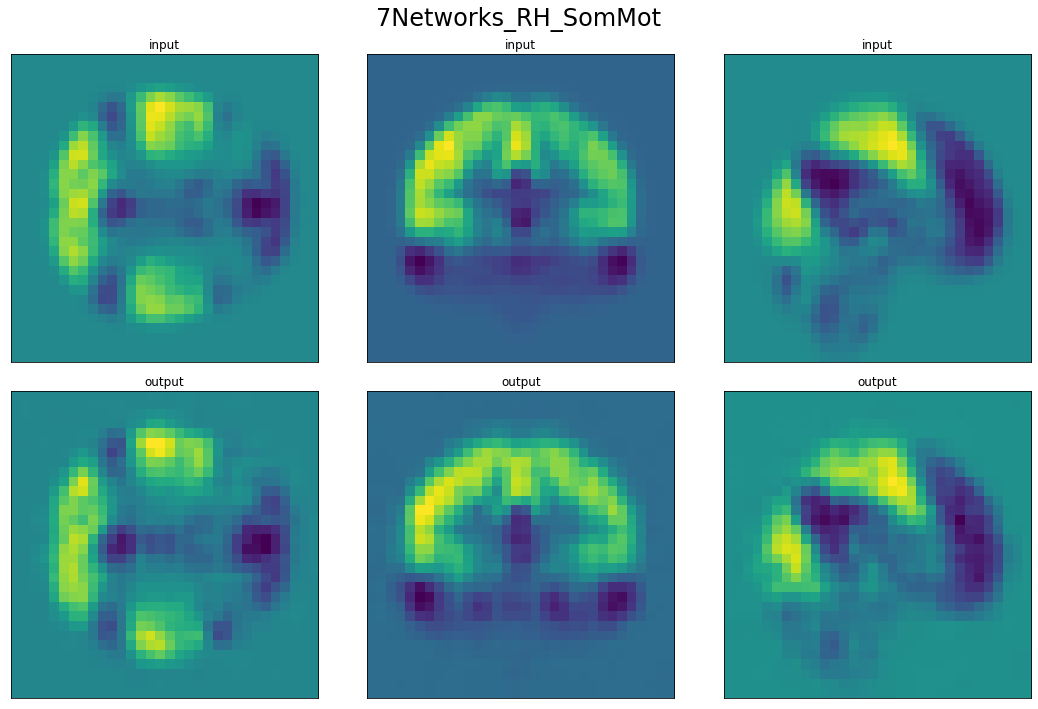

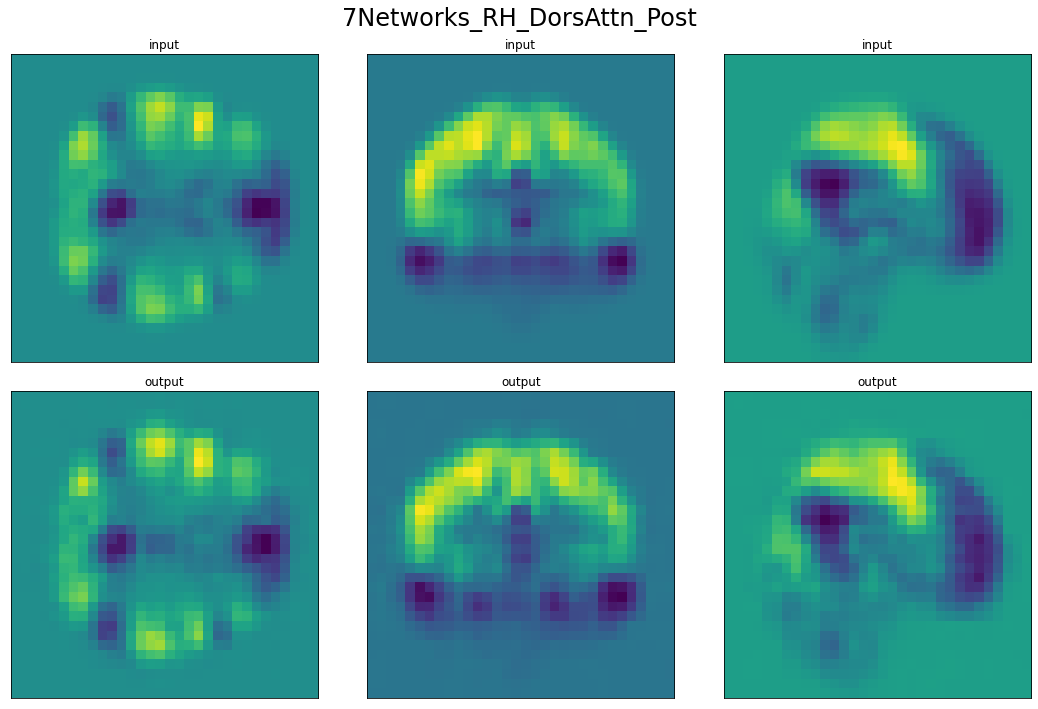

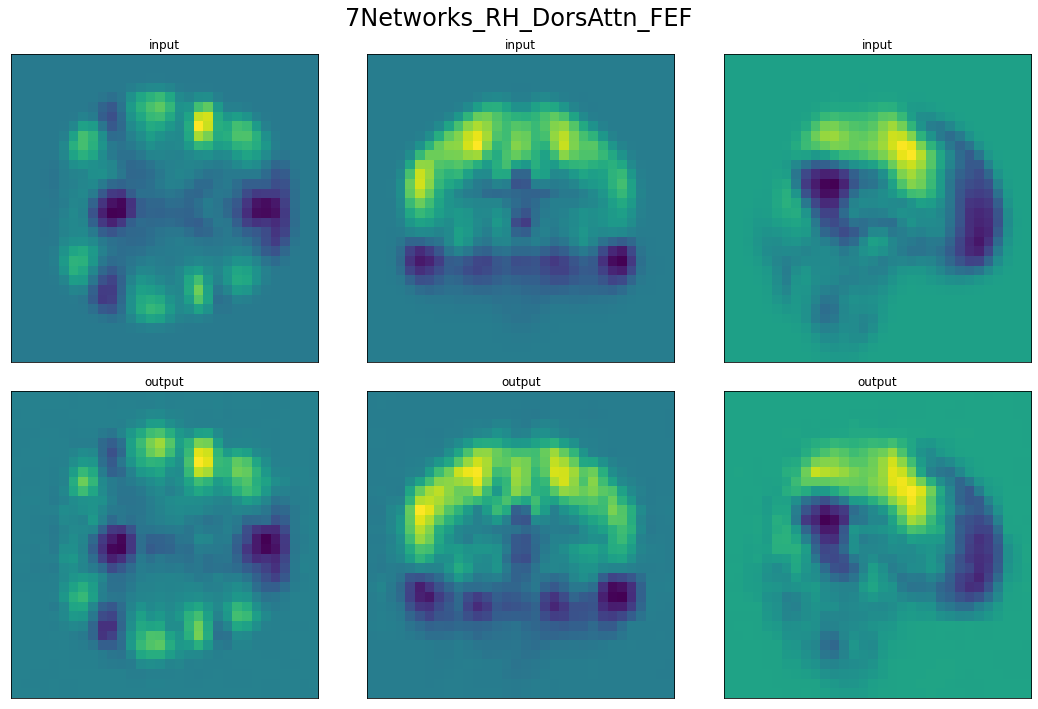

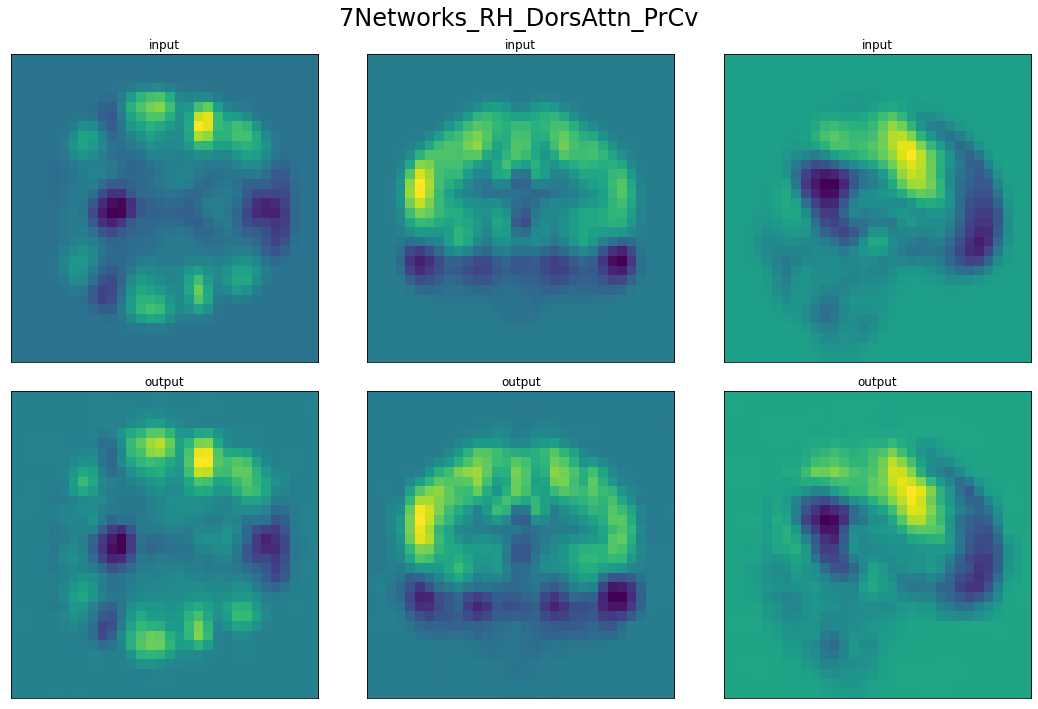

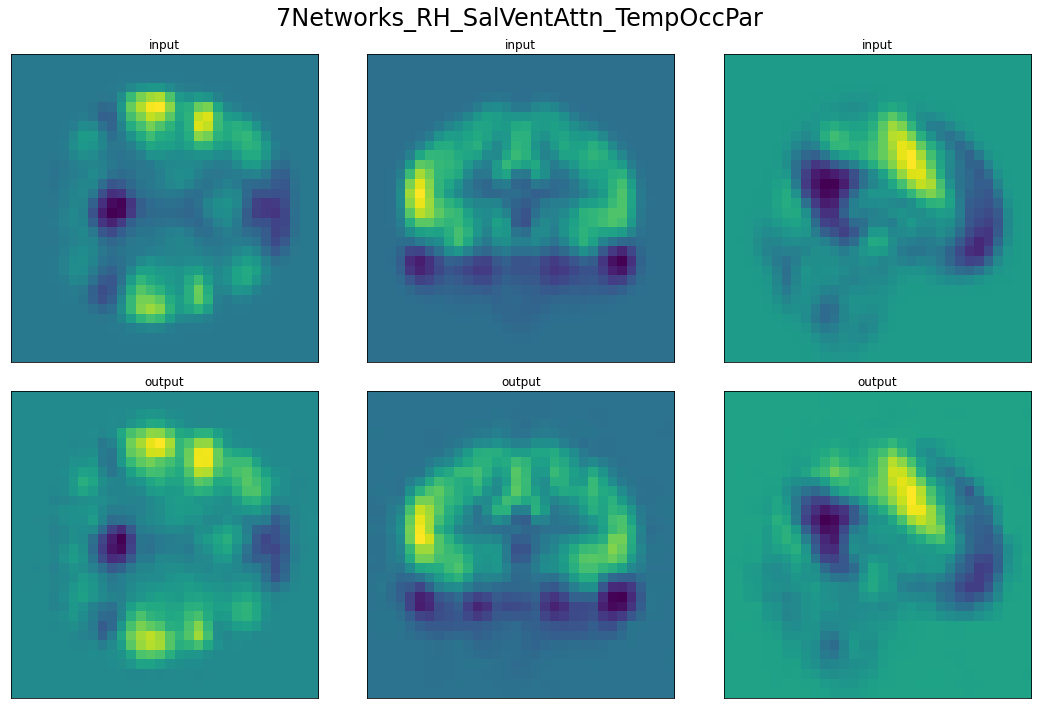

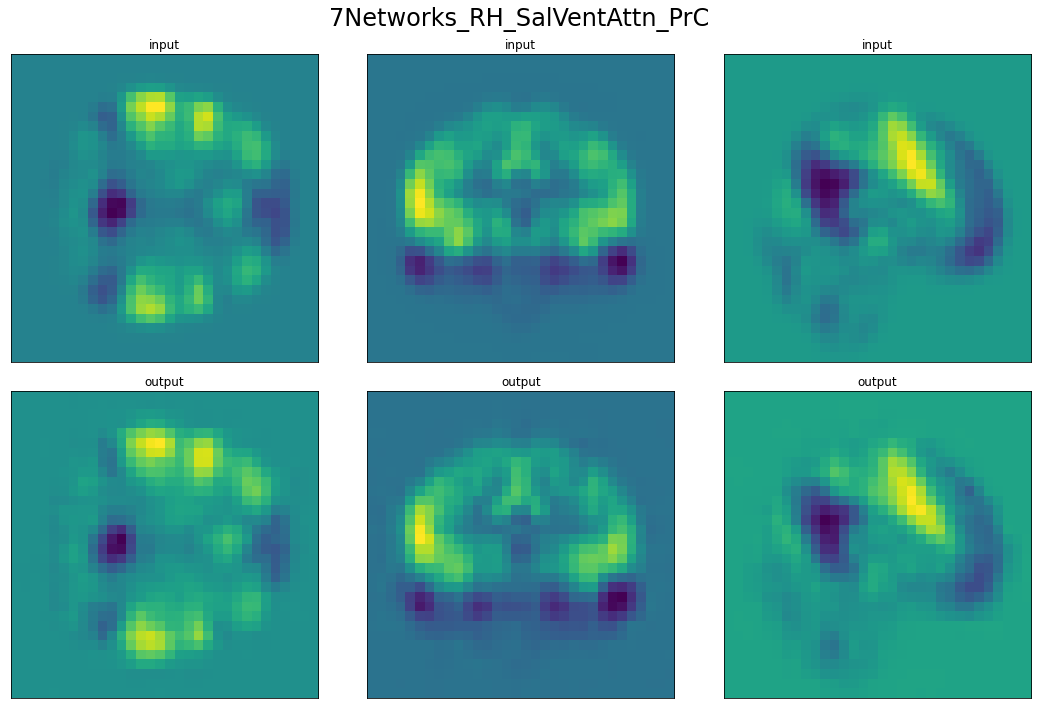

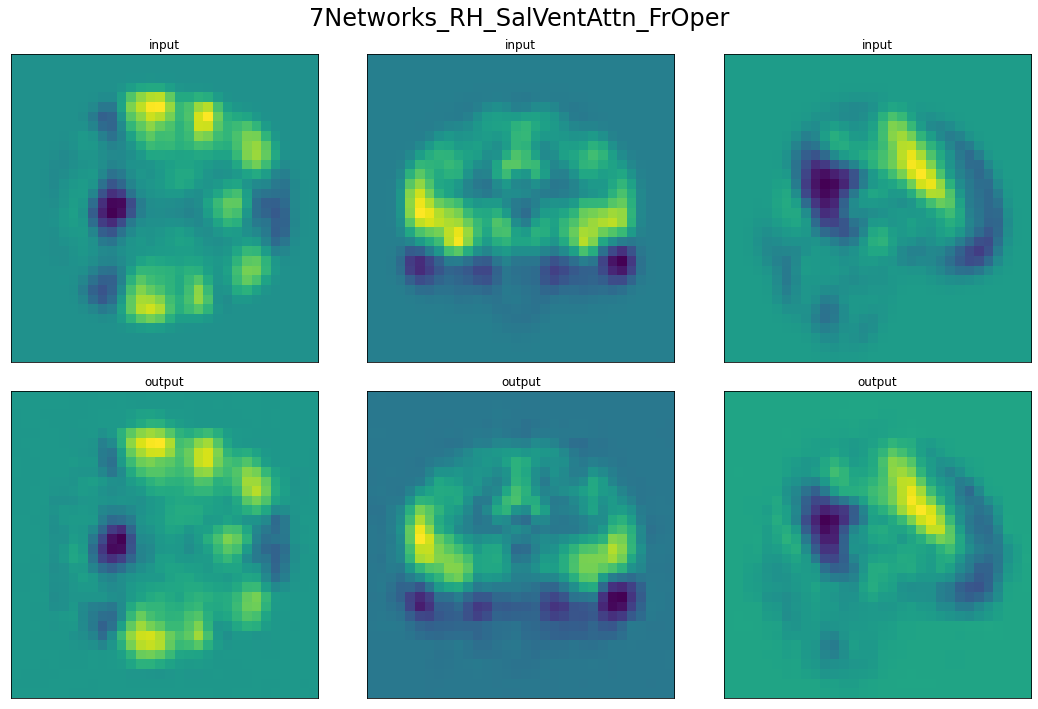

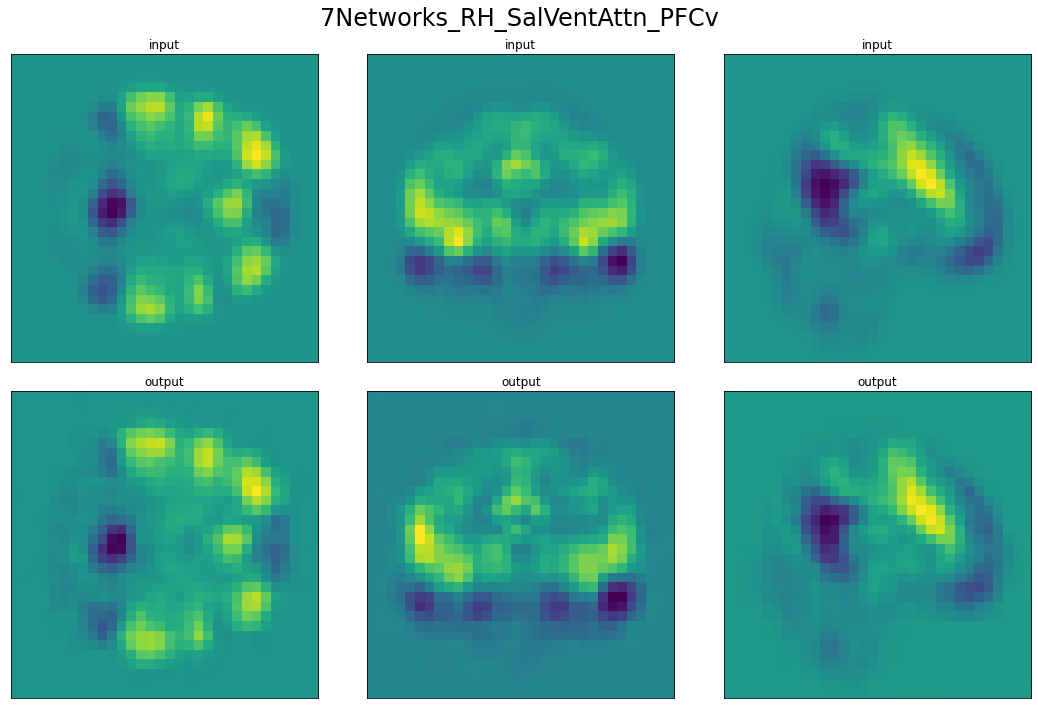

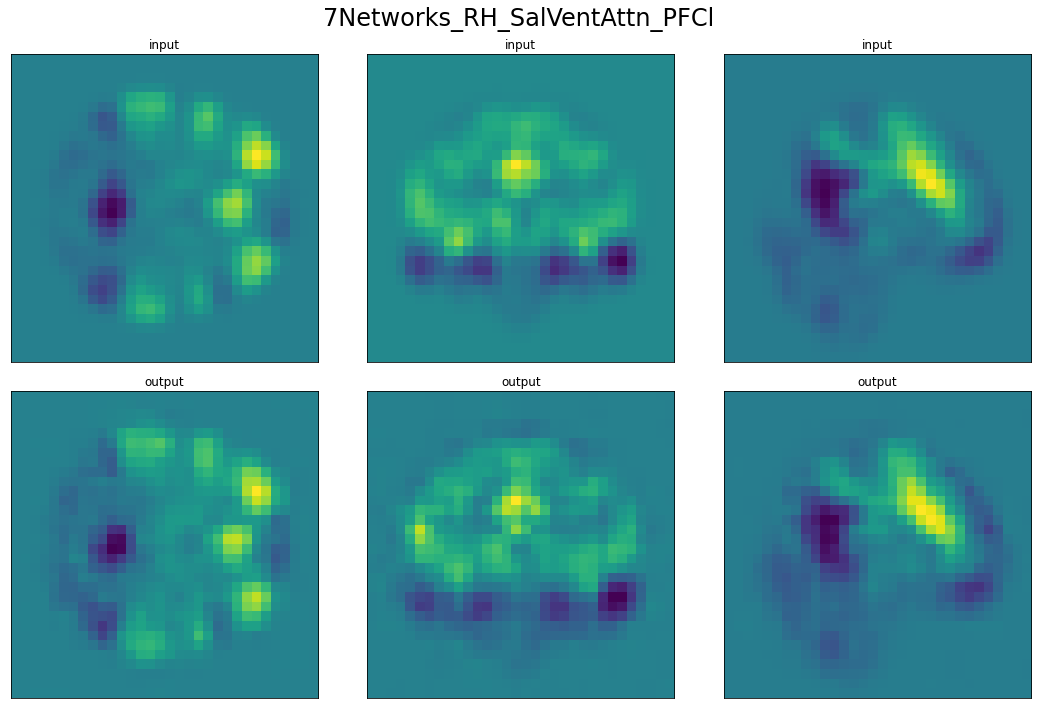

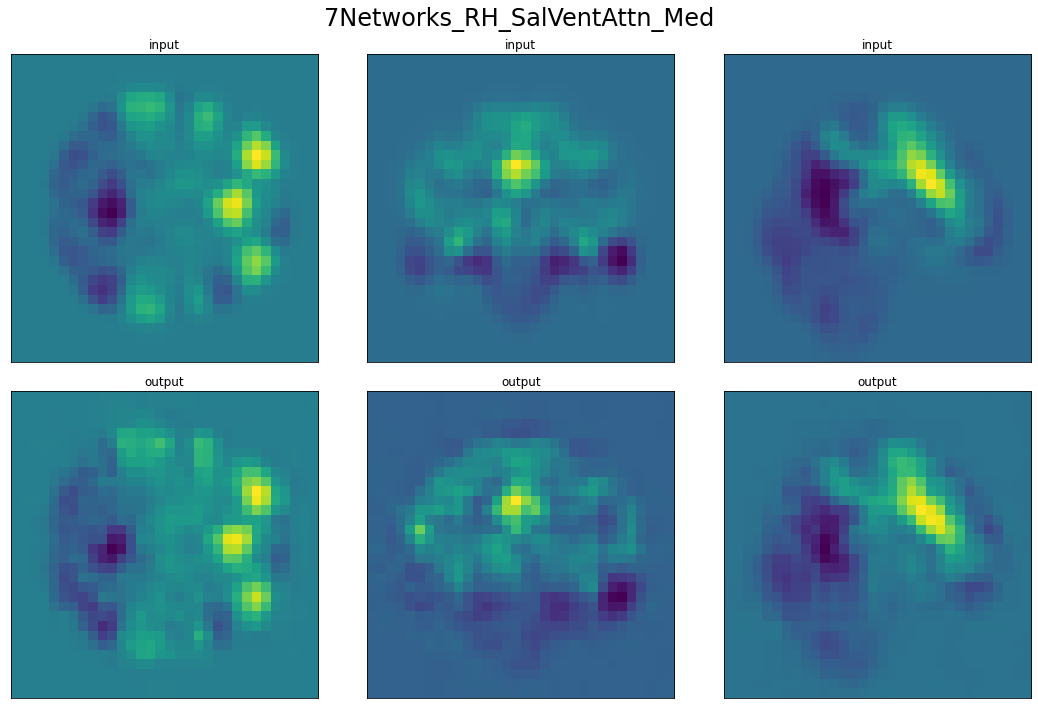

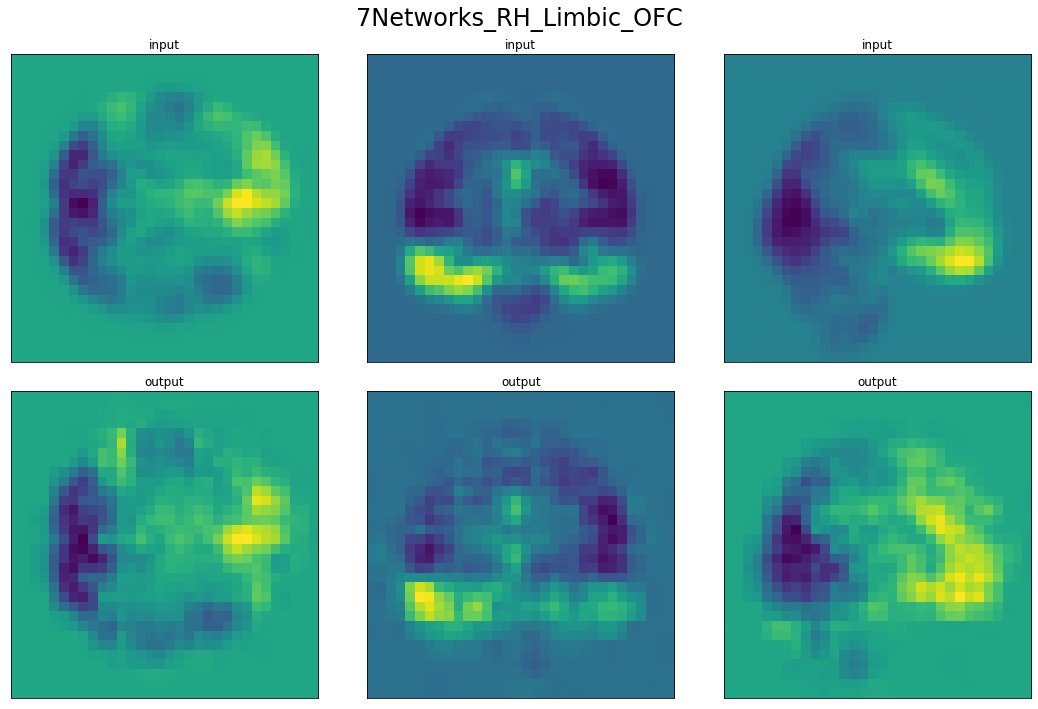

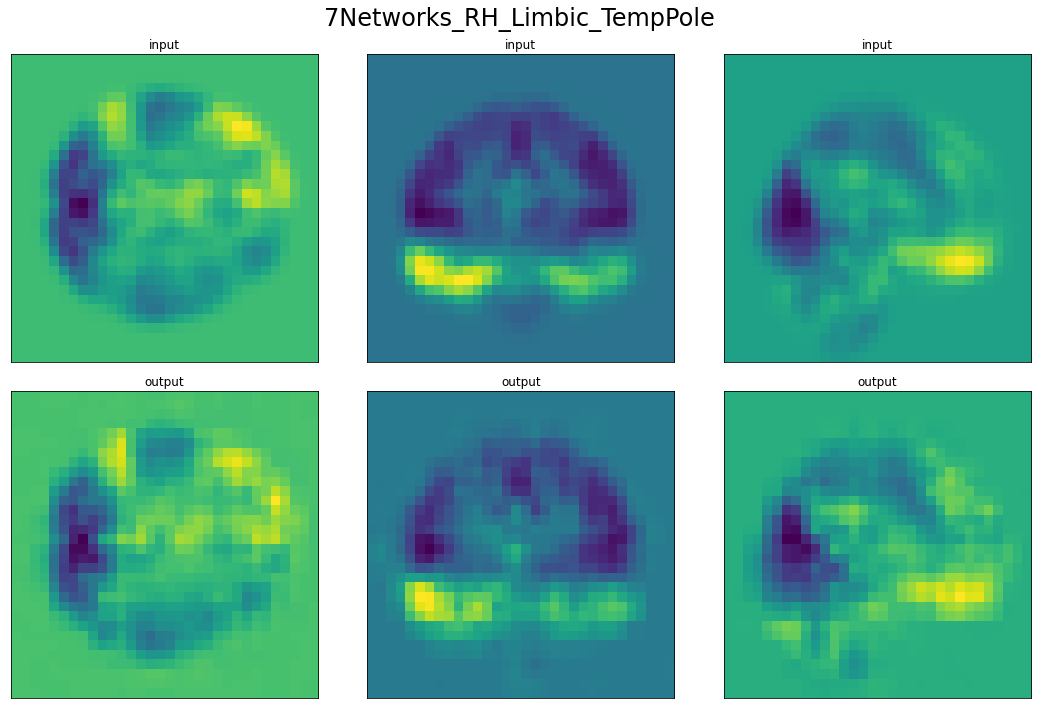

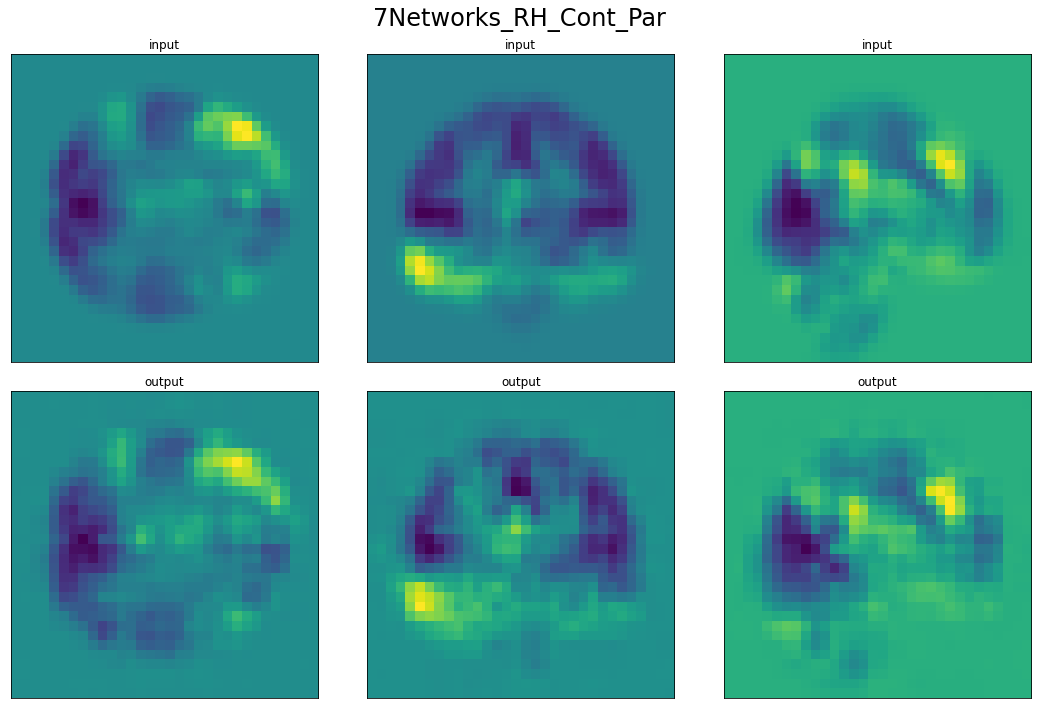

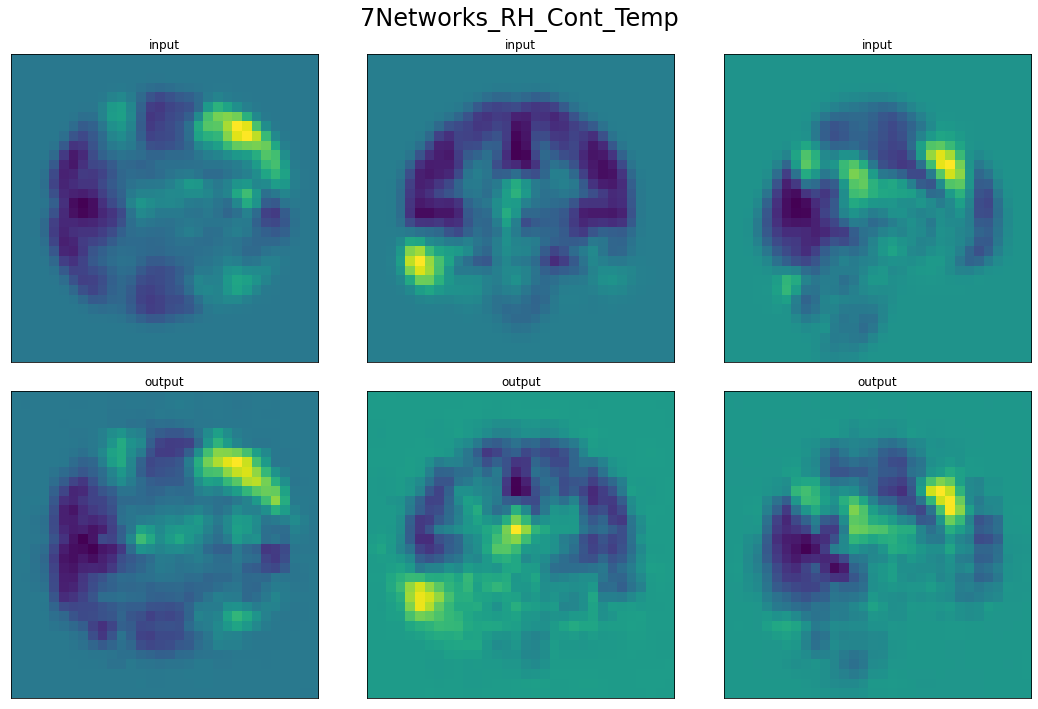

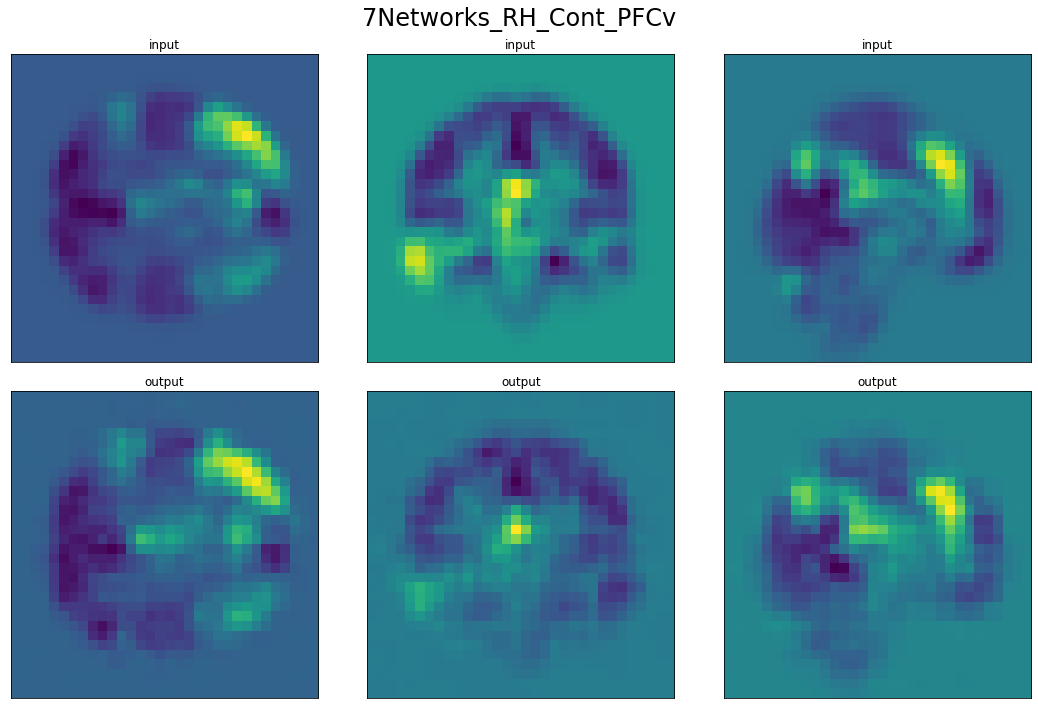

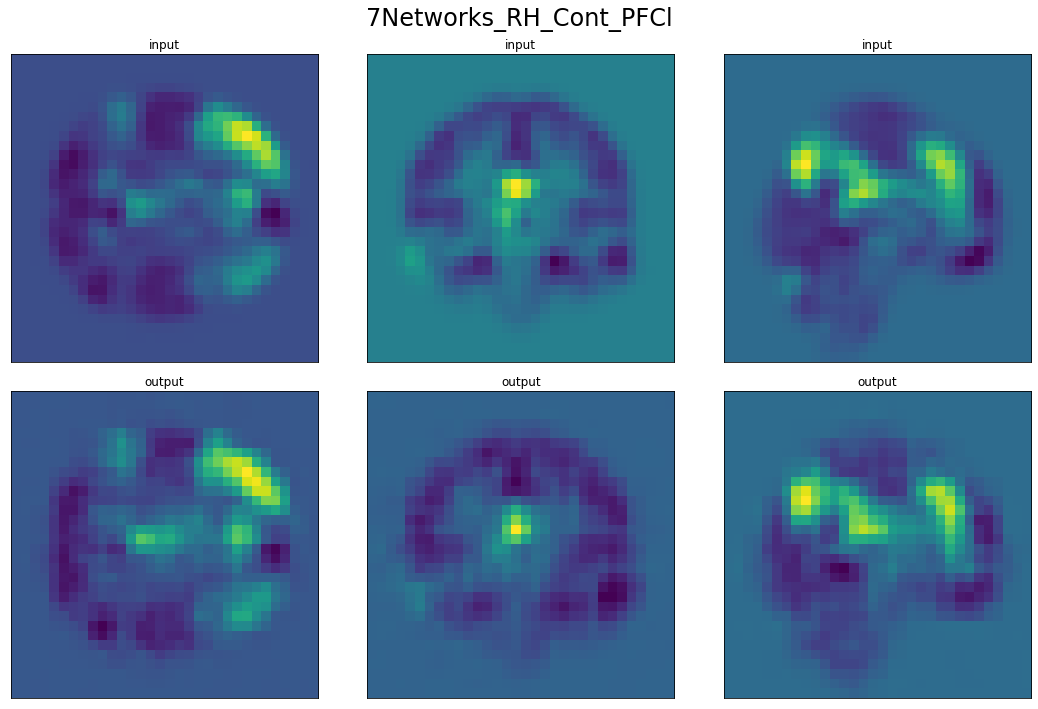

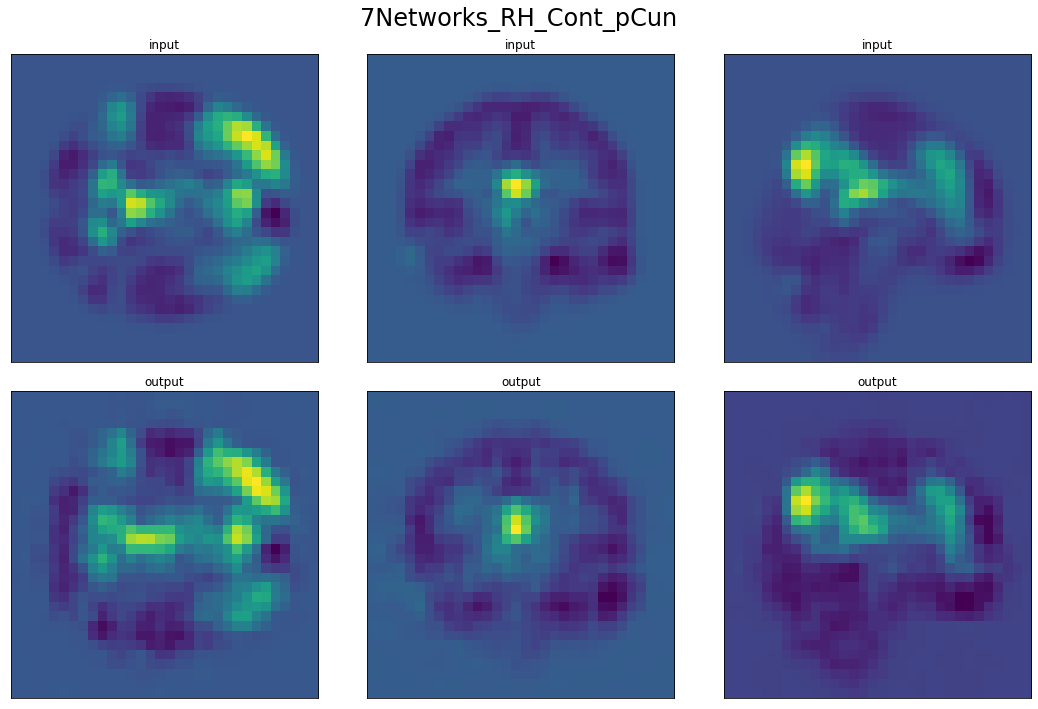

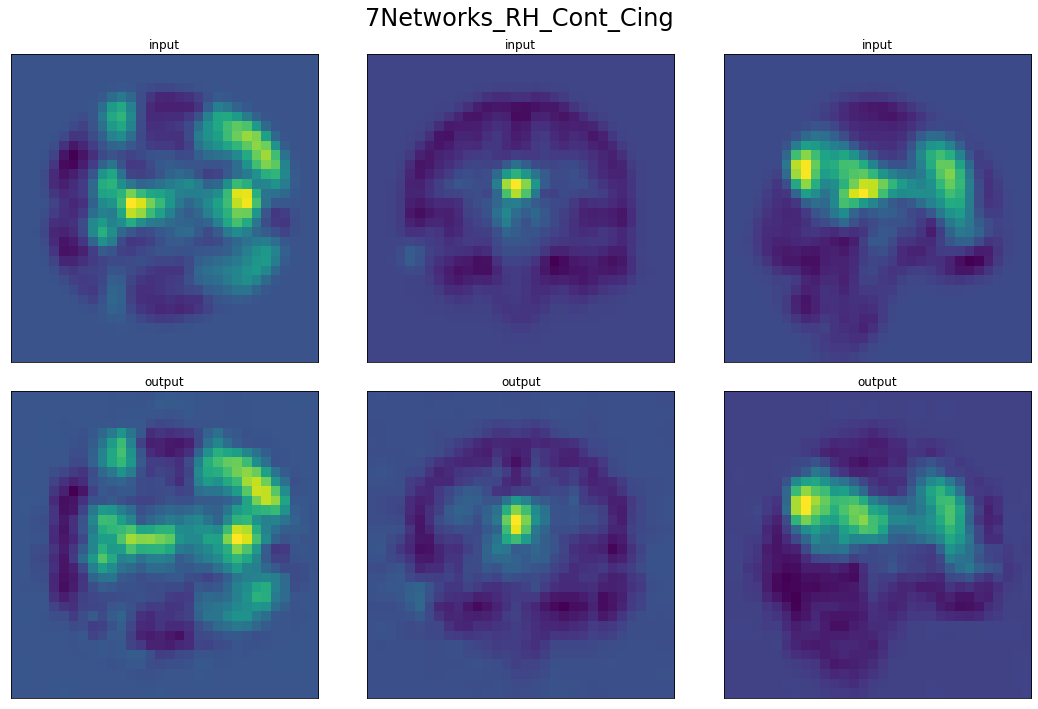

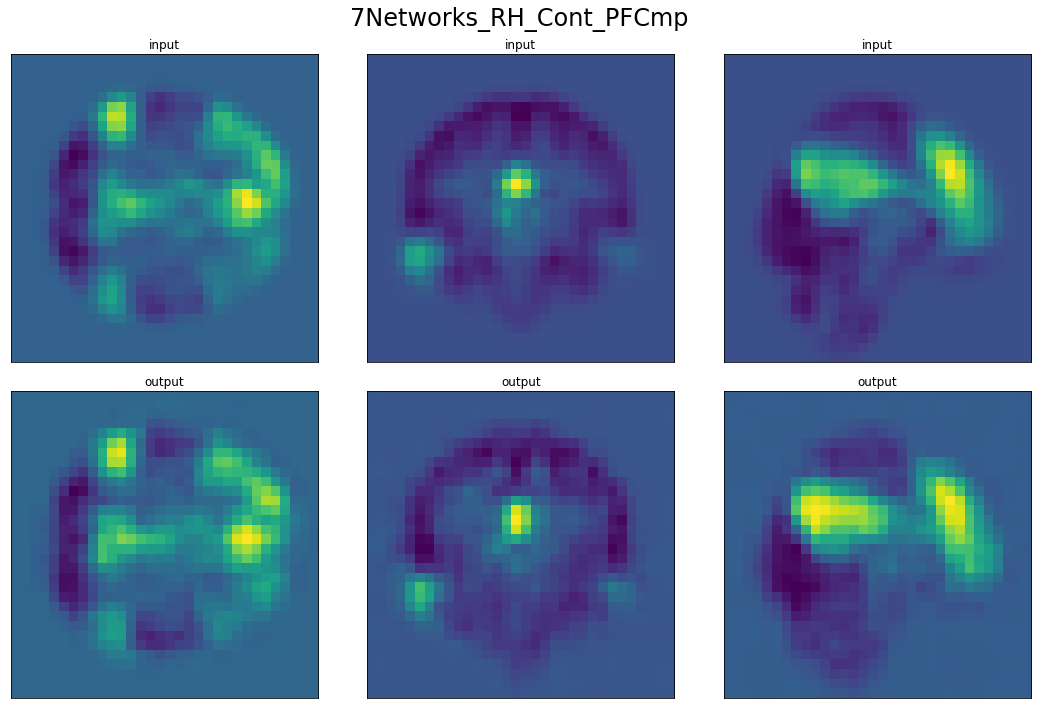

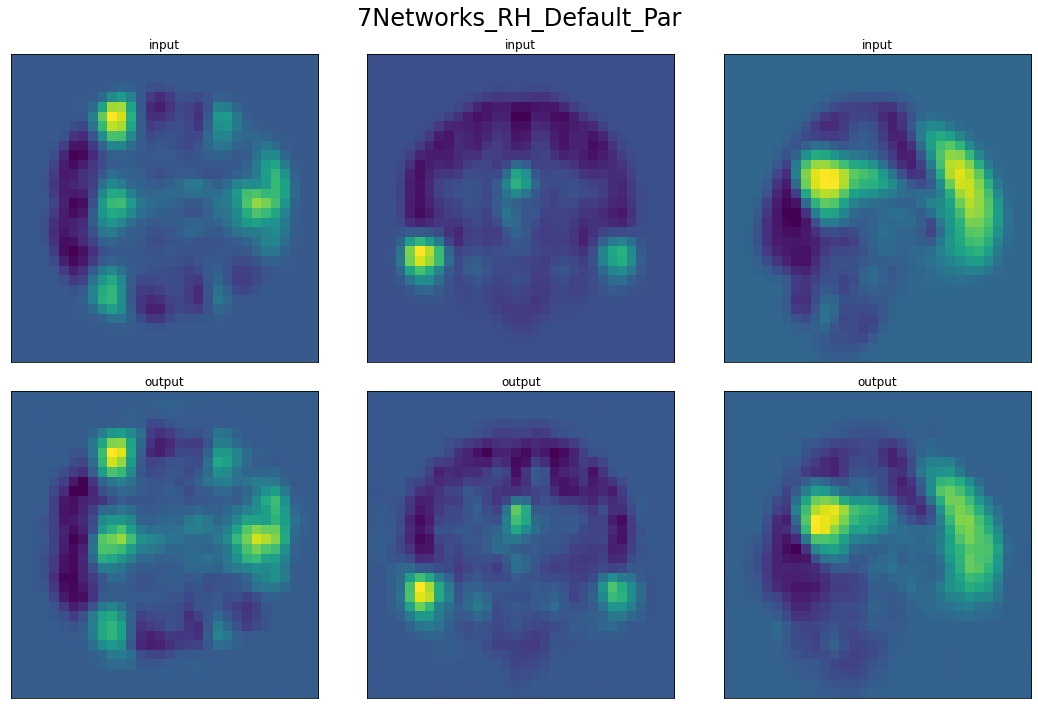

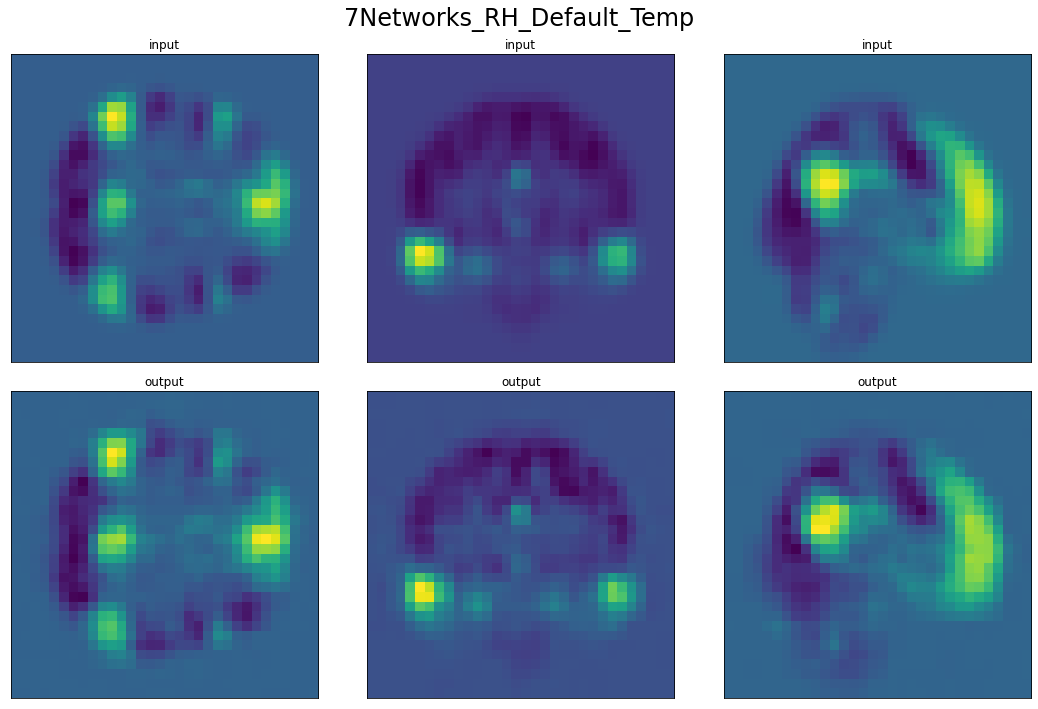

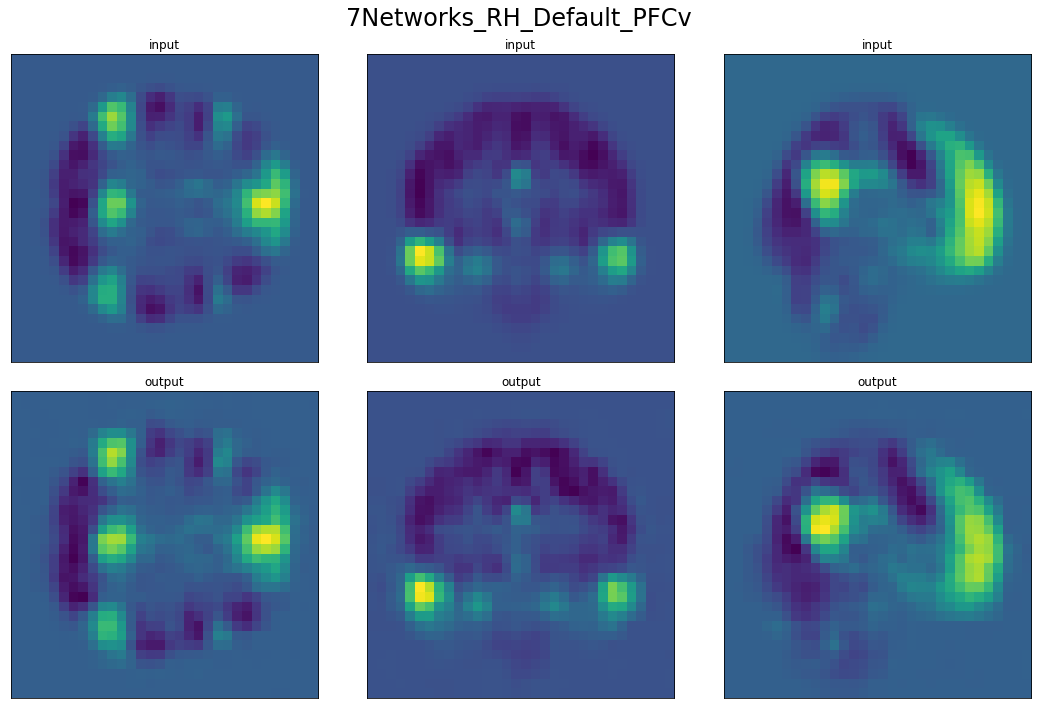

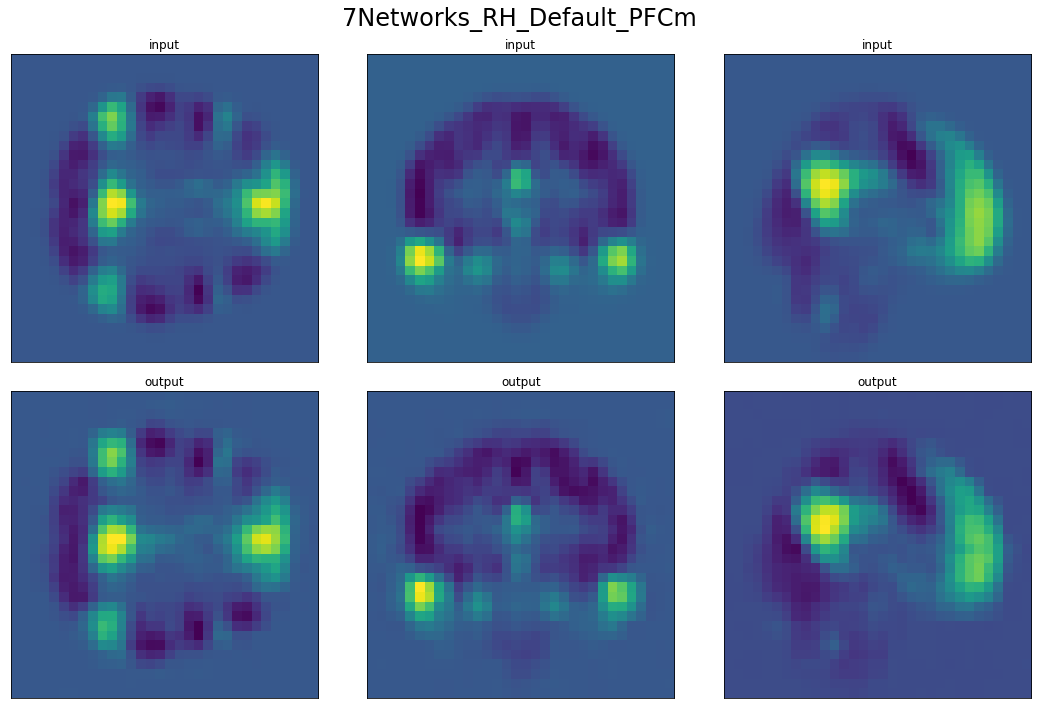

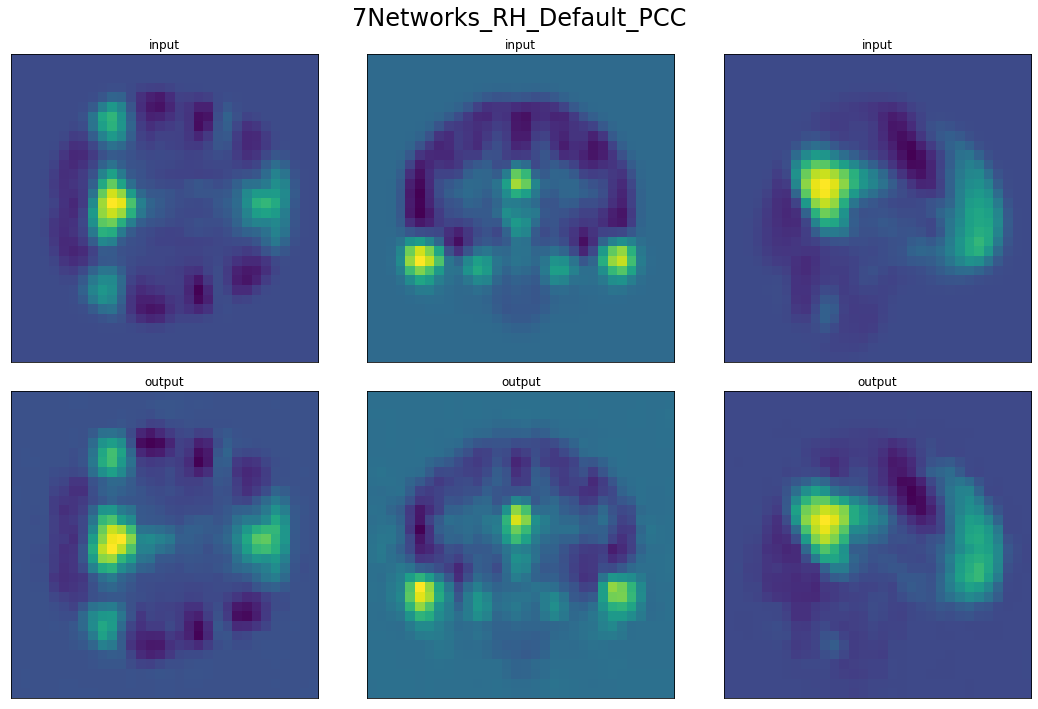

In [21]:
for i in range(51):
    plt.subplots(2,3,figsize=(15,10))

    plt.subplot(2,3,1);plt.imshow(data.mean(axis=0)[:,:,16,i]);plt.xticks([]);plt.yticks([]);plt.title('input')
    plt.subplot(2,3,4);plt.imshow(predictions.mean(axis=0)[:,:,16,i]);plt.xticks([]);plt.yticks([]);plt.title('output')

    plt.subplot(2,3,2);plt.imshow(np.rot90(data.mean(axis=0)[:,16,:,i]));plt.xticks([]);plt.yticks([]);plt.title('input')
    plt.subplot(2,3,5);plt.imshow(np.rot90(predictions.mean(axis=0)[:,16,:,i]));plt.xticks([]);plt.yticks([]);plt.title('output')

    plt.subplot(2,3,3);plt.imshow(np.rot90(data.mean(axis=0)[16,:,:,i]));plt.xticks([]);plt.yticks([]);plt.title('input')
    plt.subplot(2,3,6);plt.imshow(np.rot90(predictions.mean(axis=0)[16,:,:,i]));plt.xticks([]);plt.yticks([]);plt.title('output')

    plt.suptitle(rlbls[i],fontsize=24)
    plt.tight_layout()

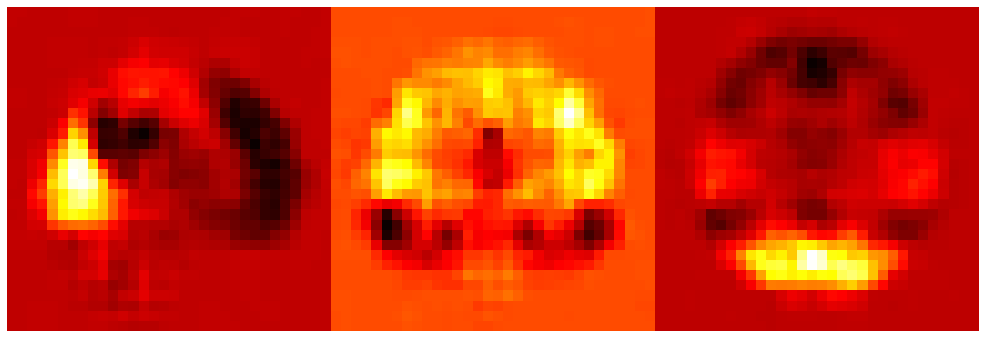

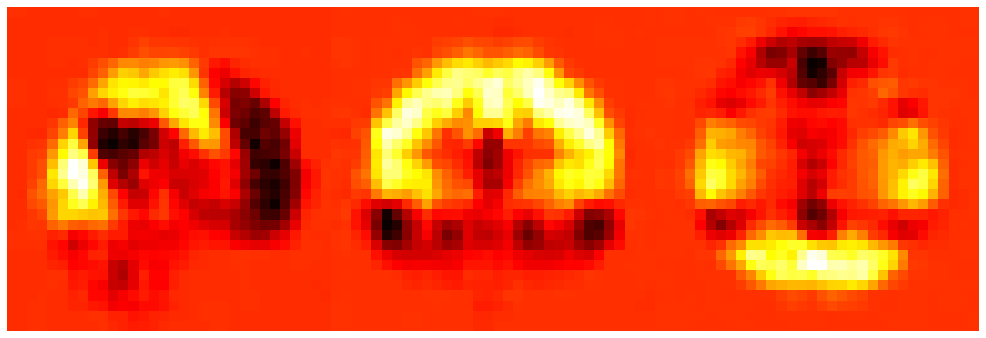

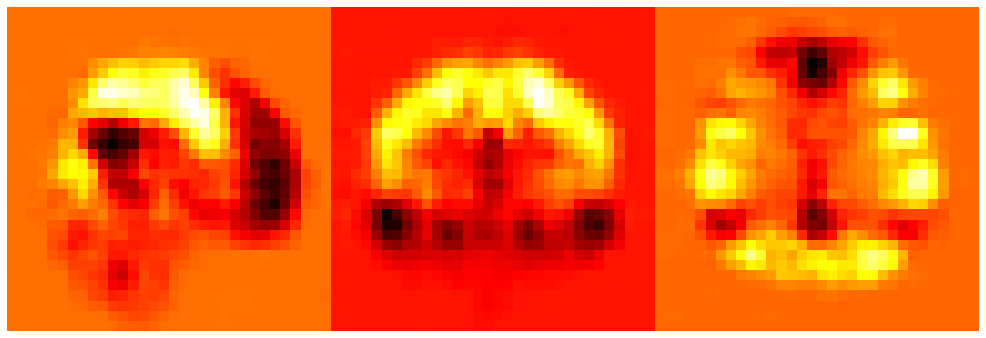

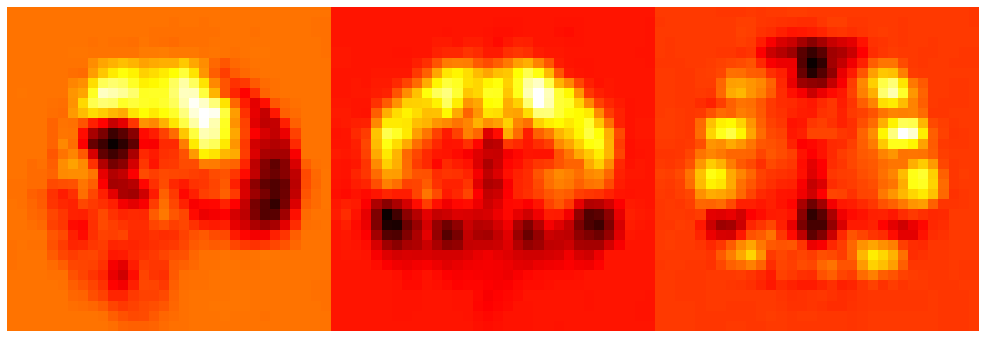

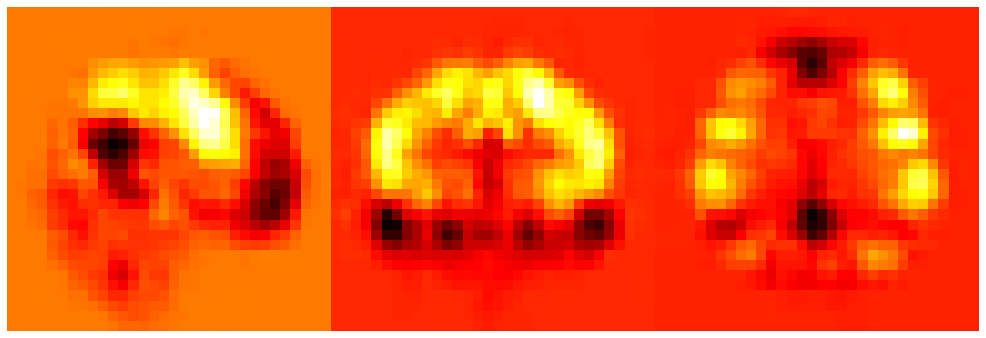

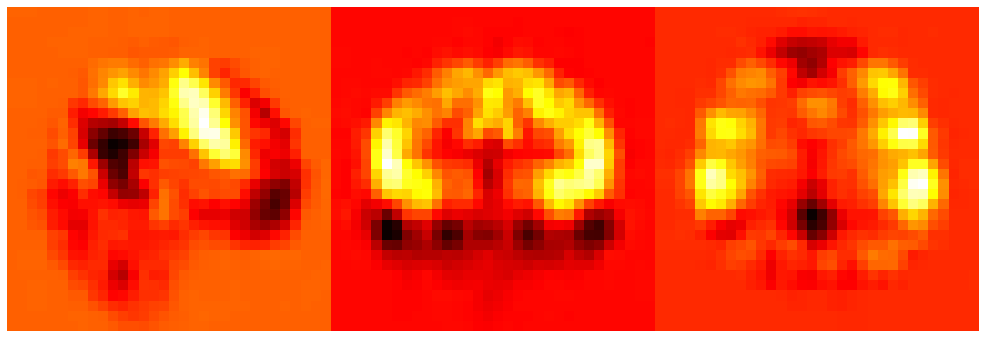

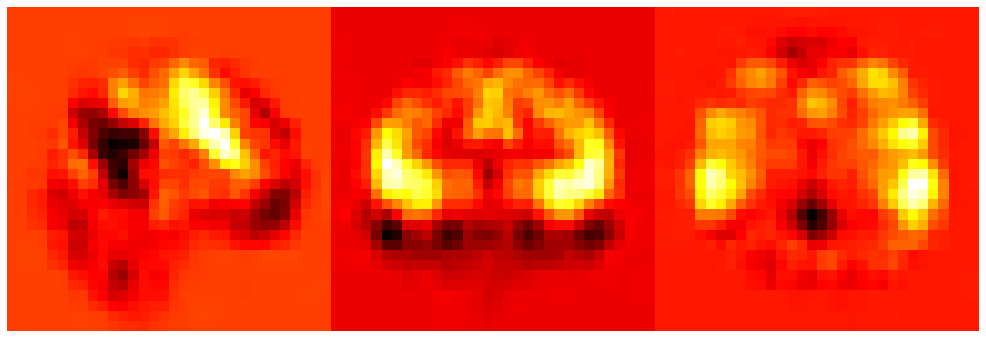

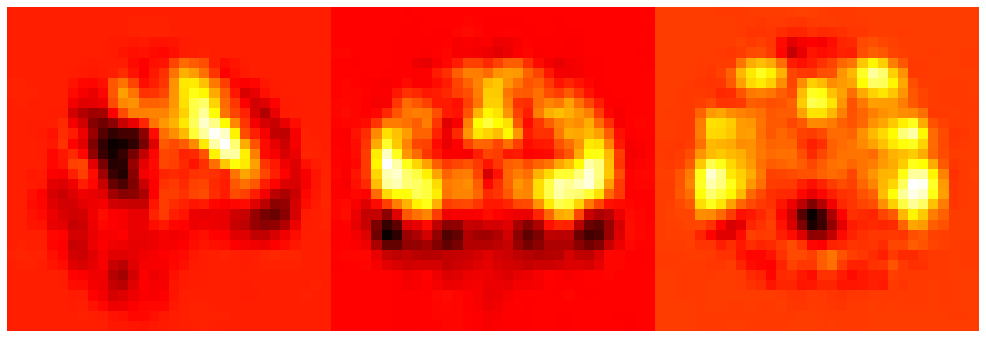

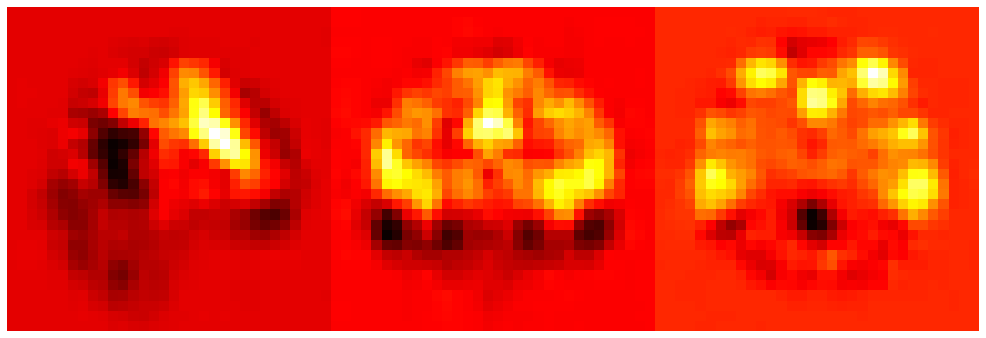

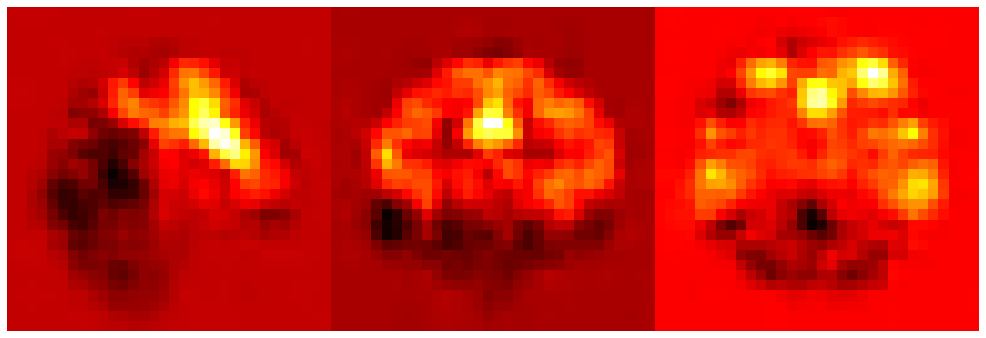

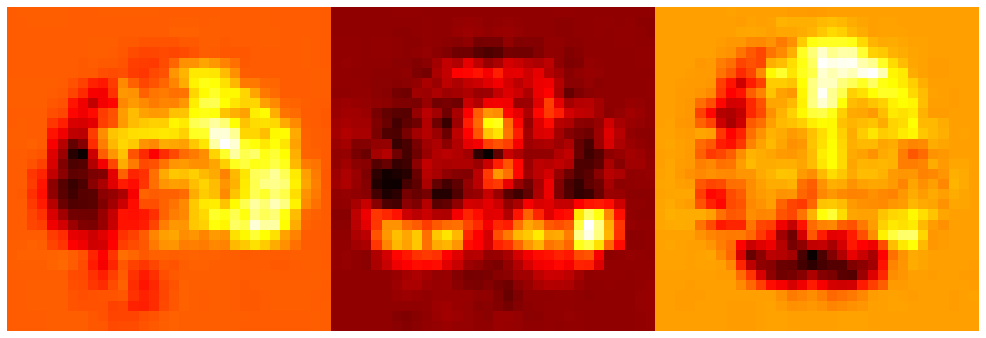

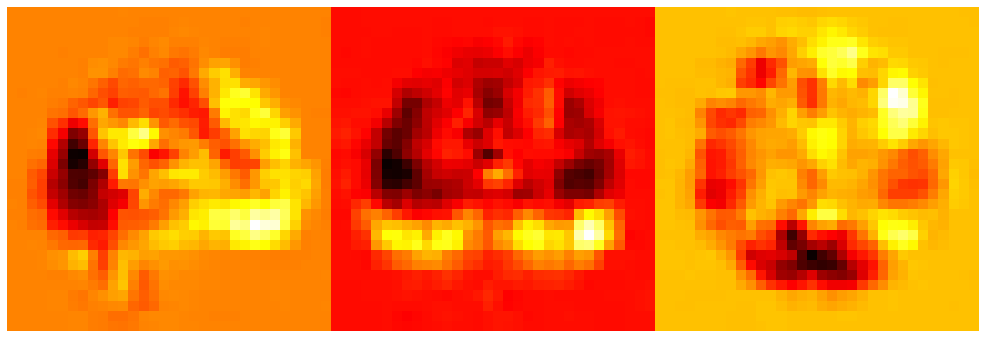

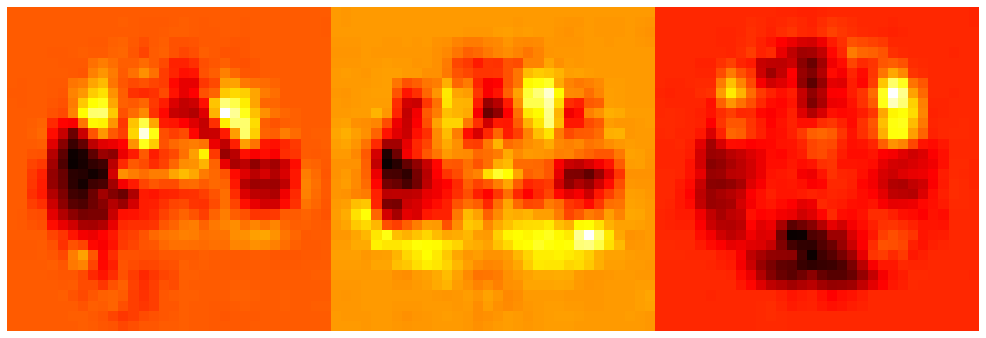

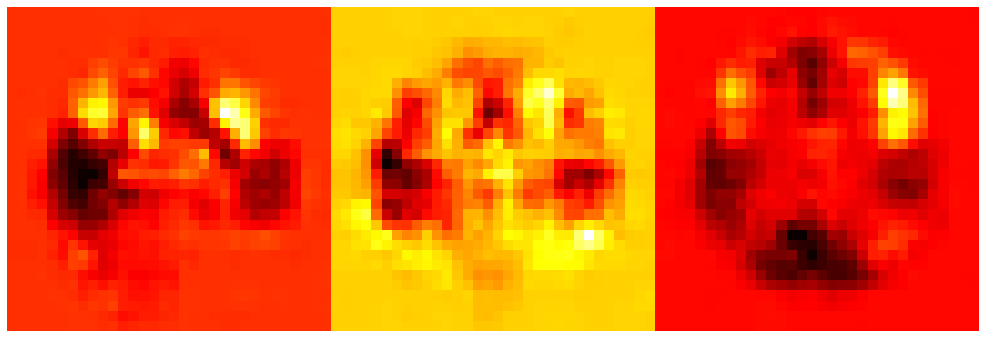

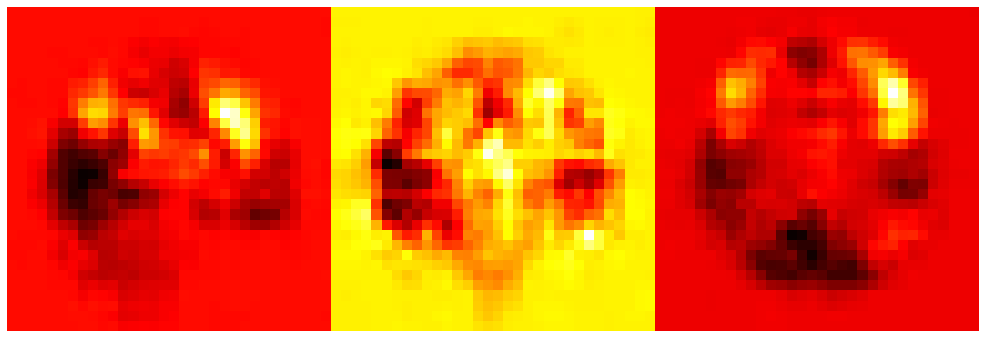

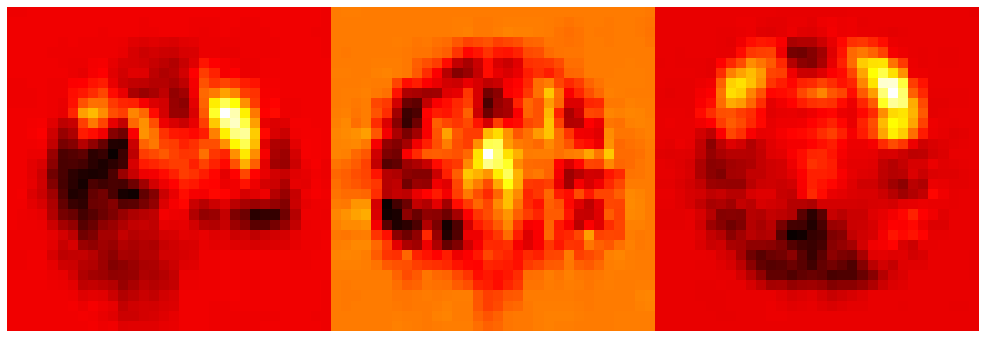

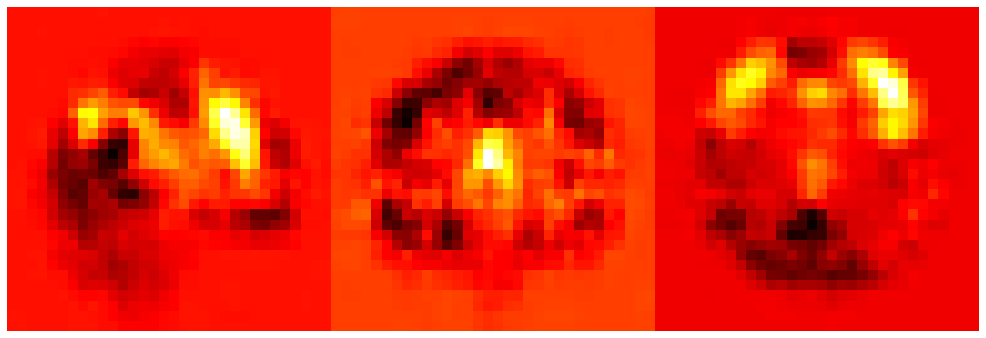

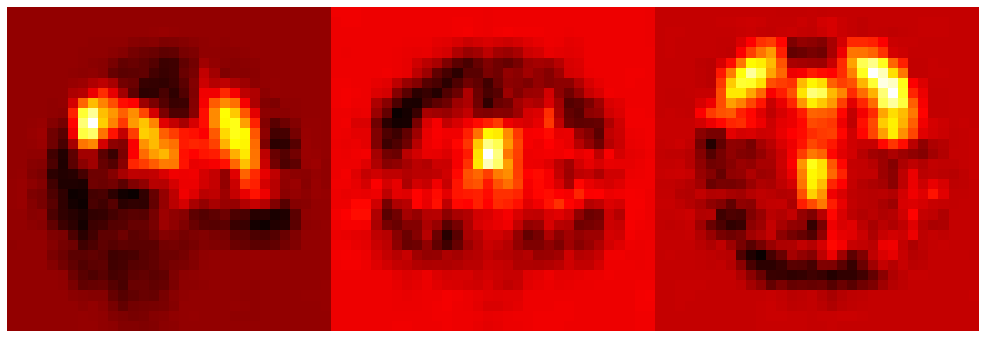

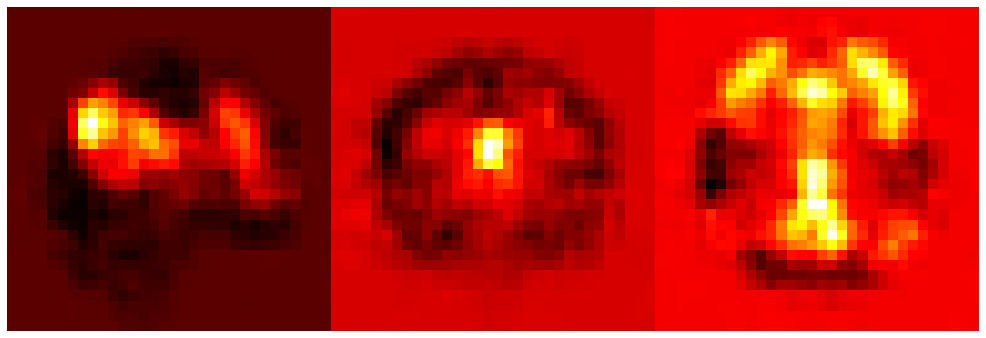

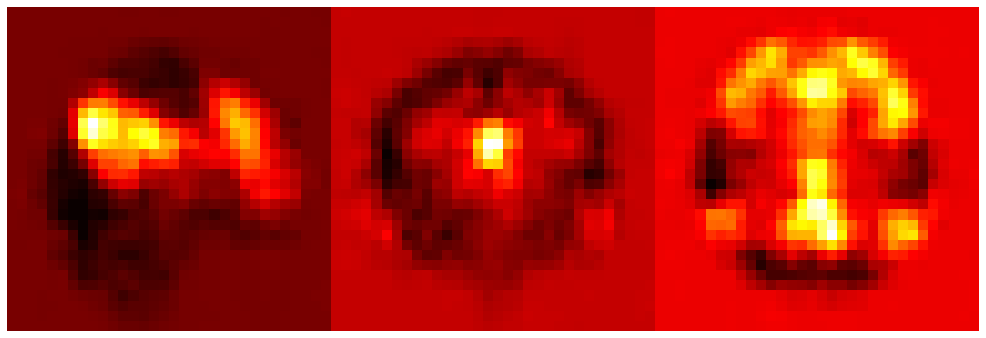

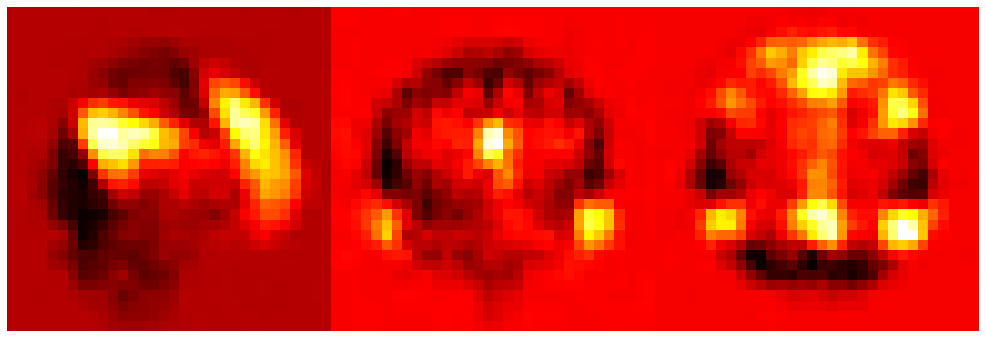

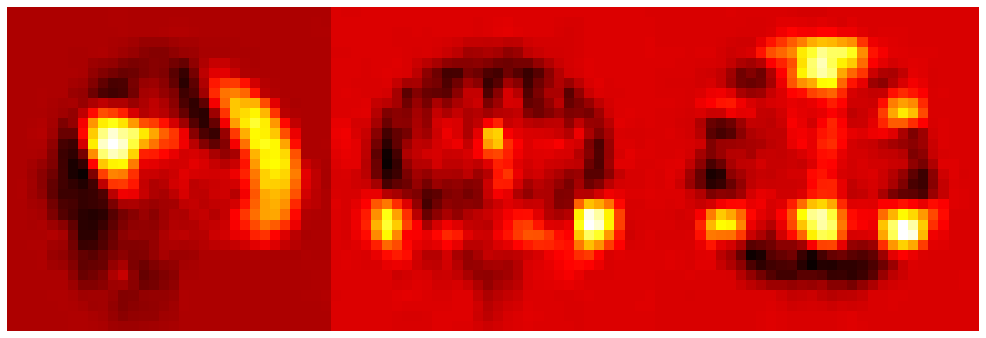

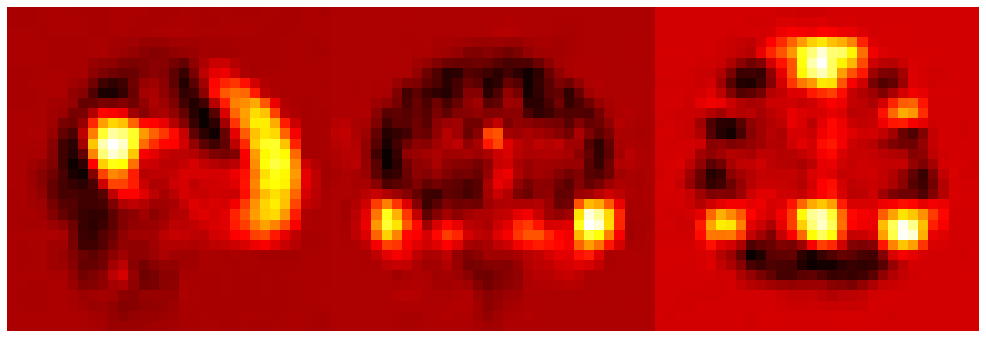

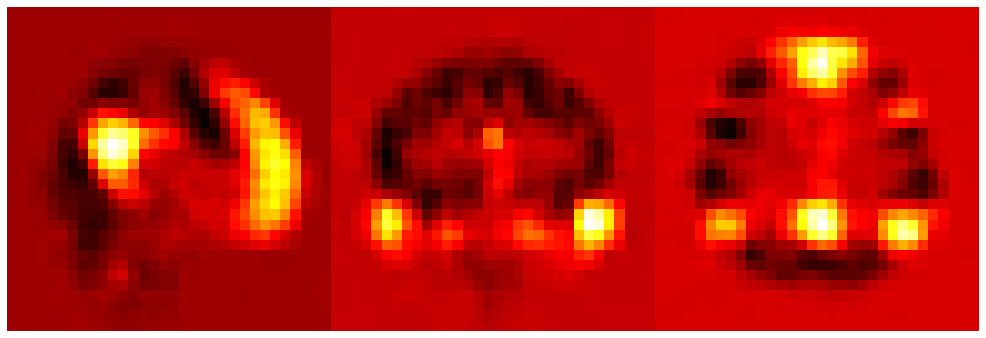

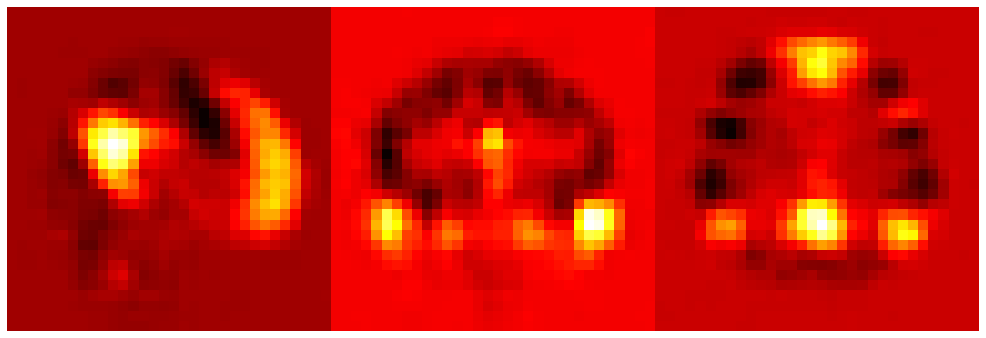

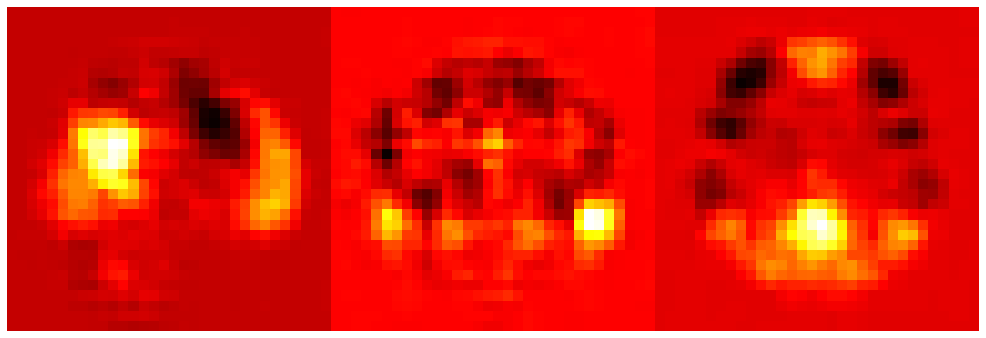

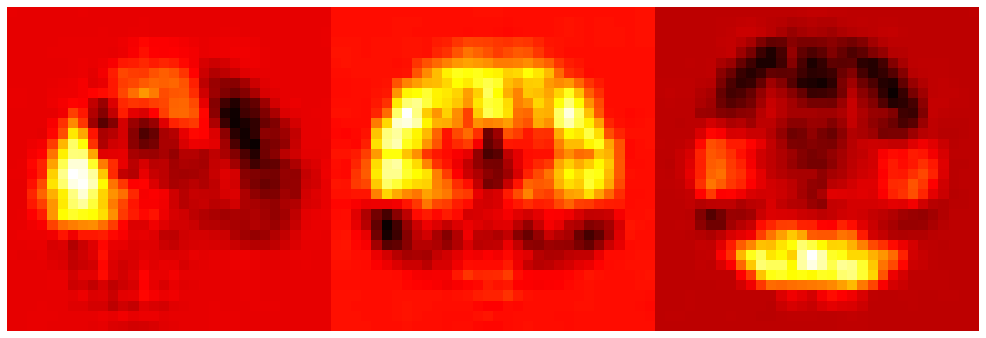

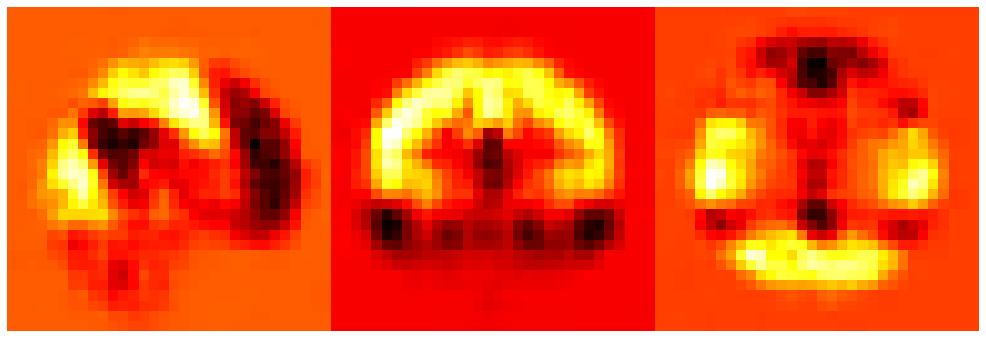

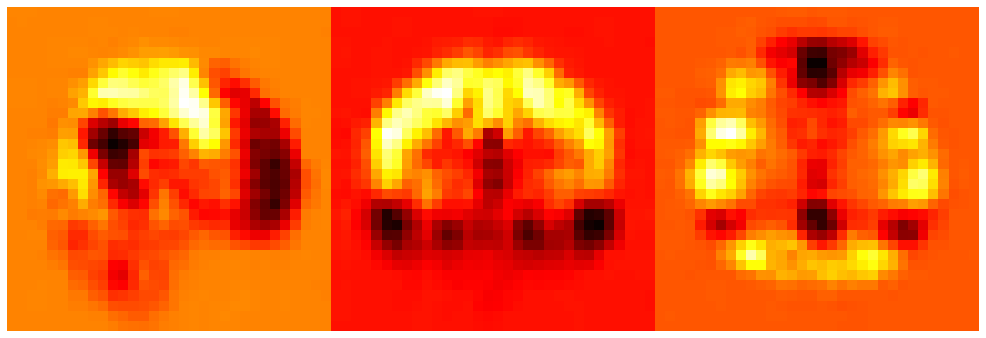

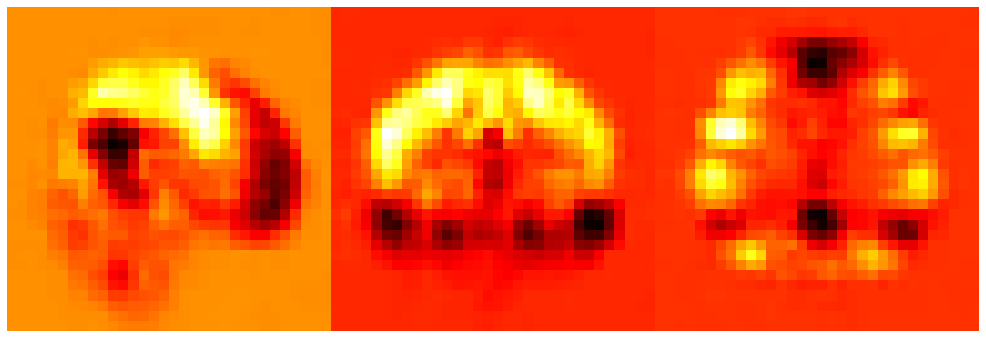

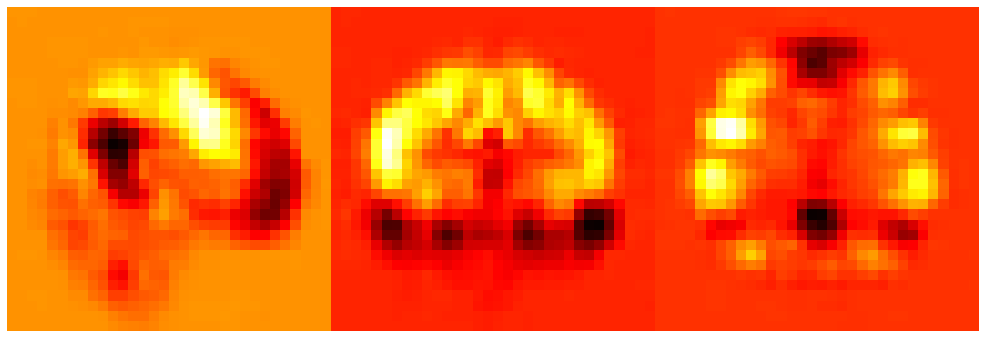

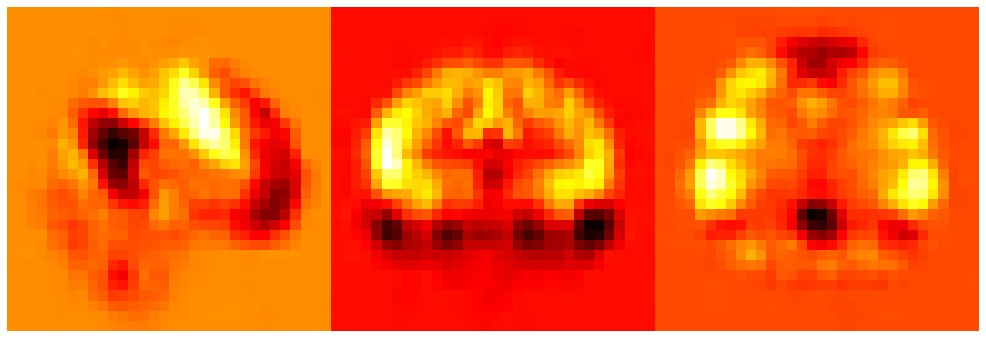

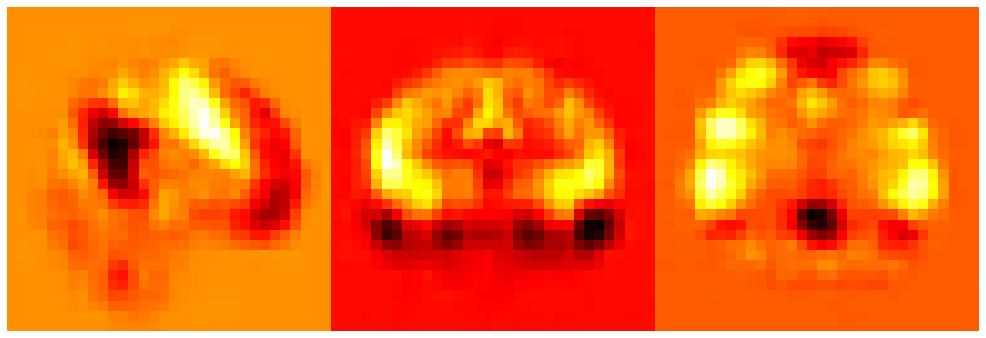

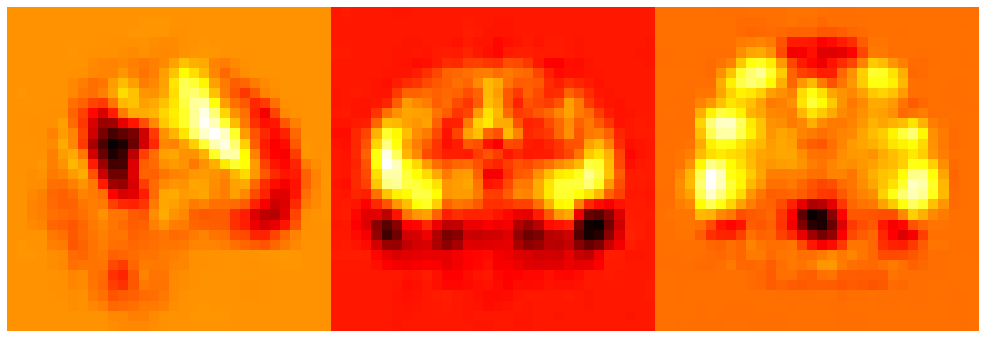

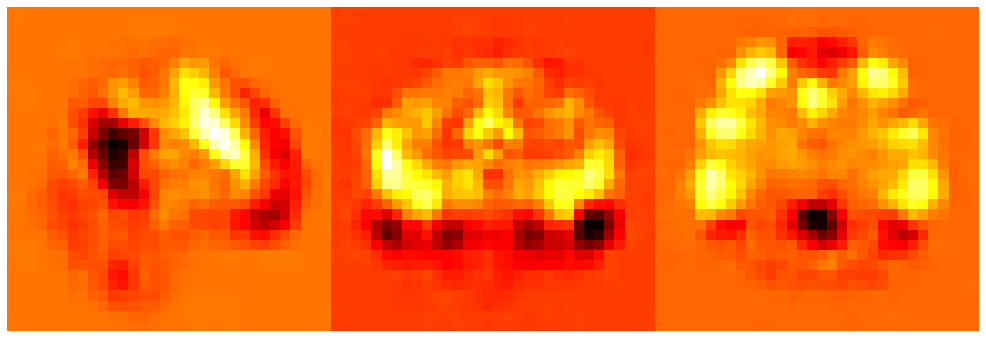

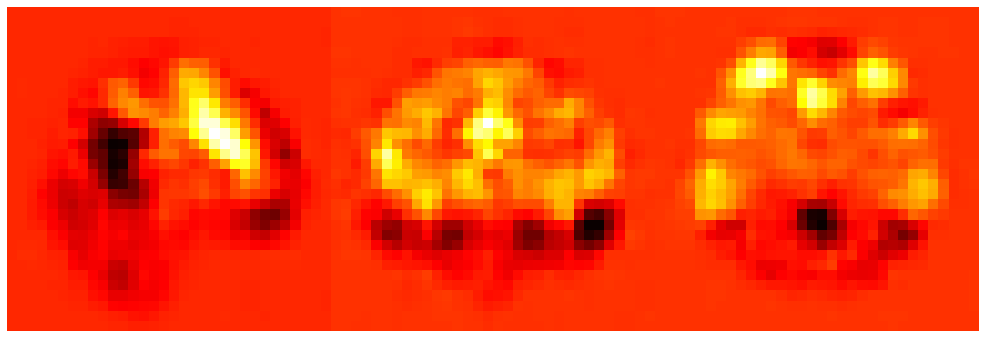

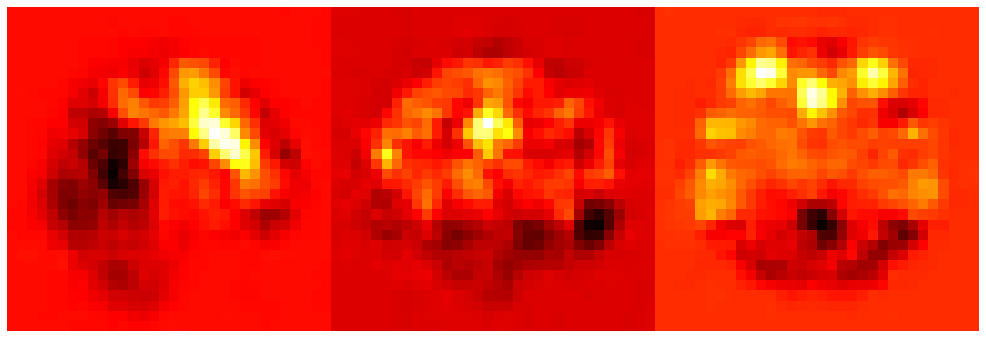

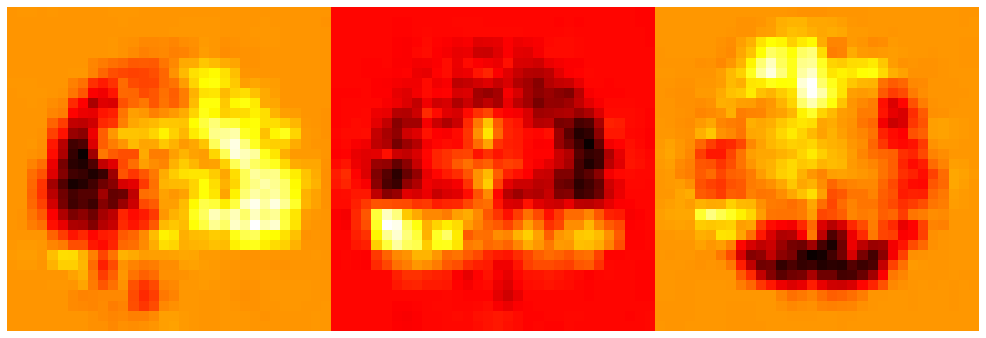

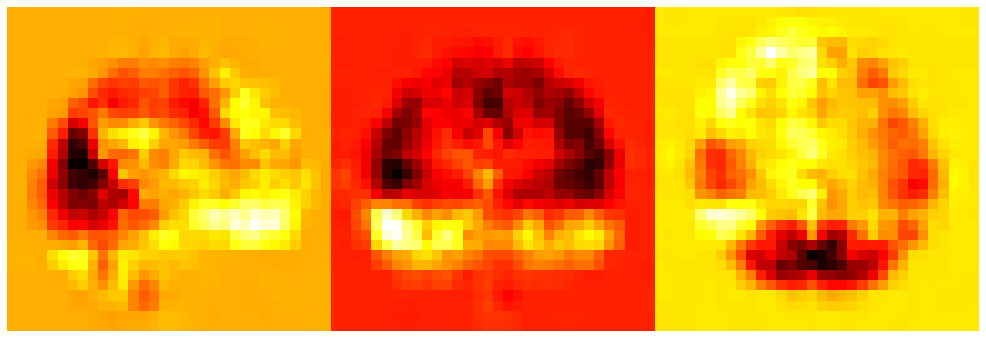

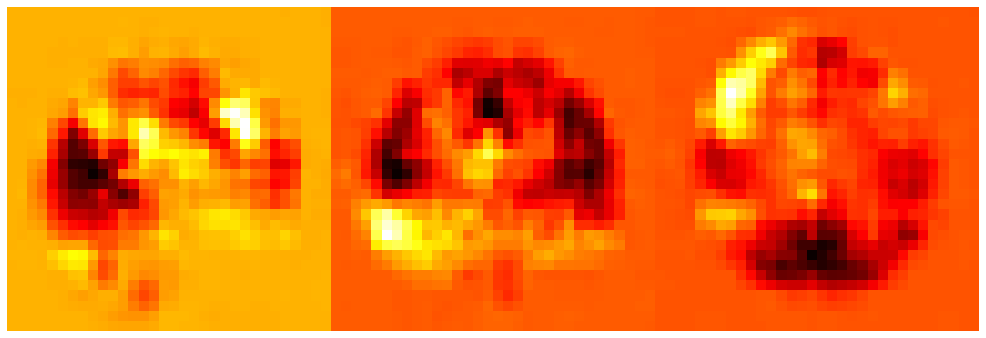

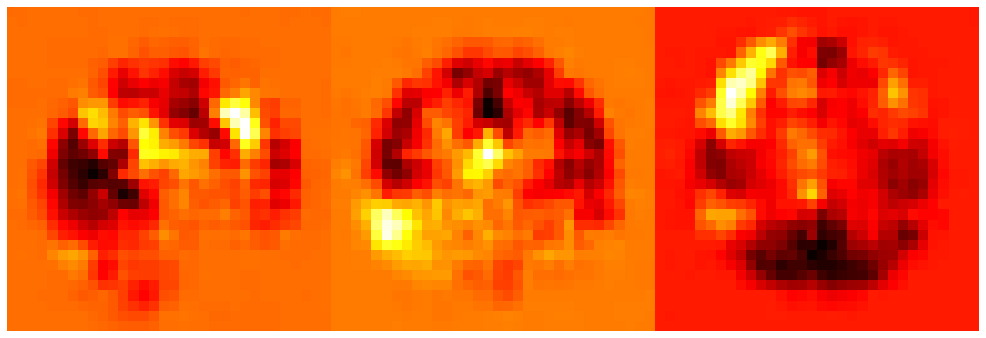

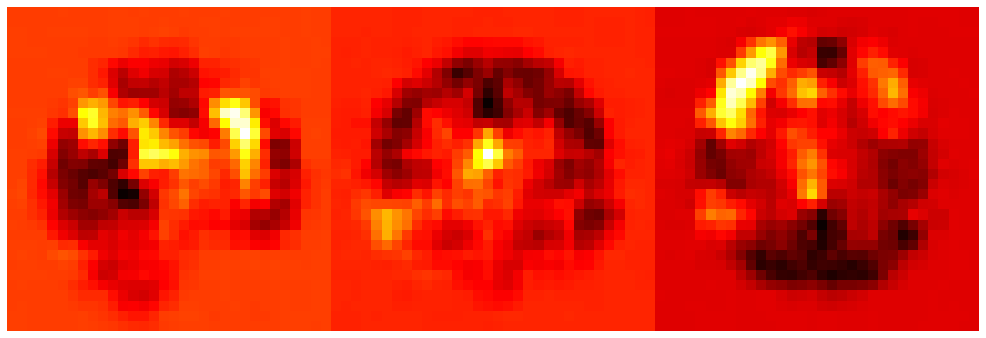

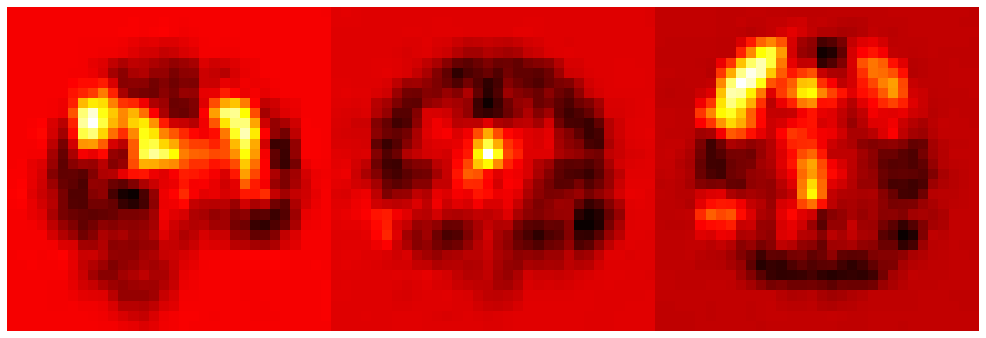

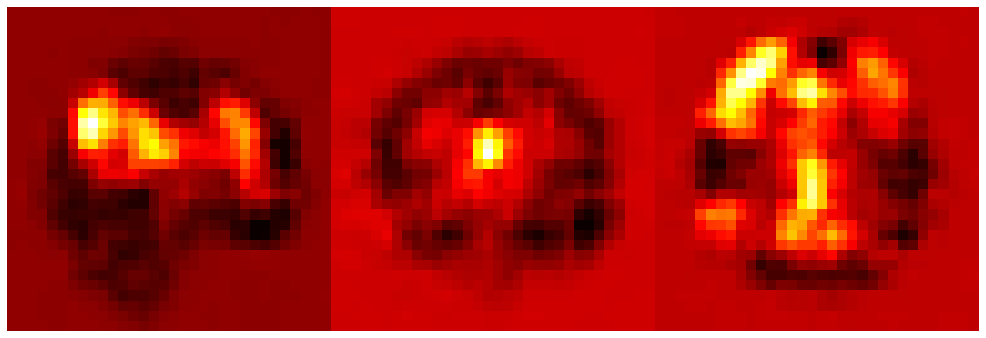

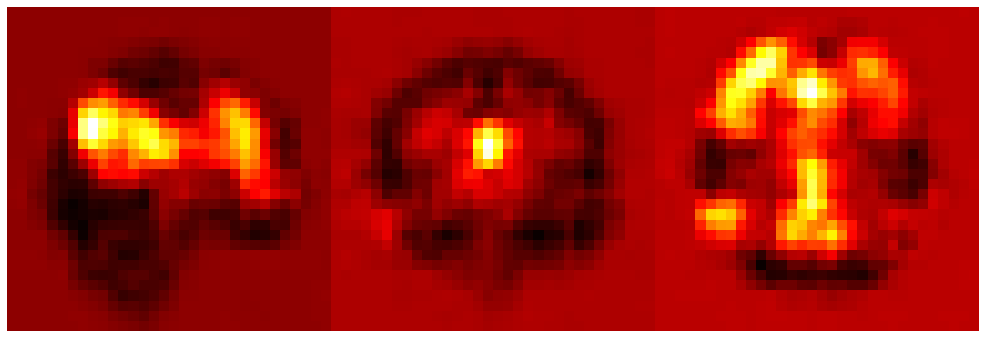

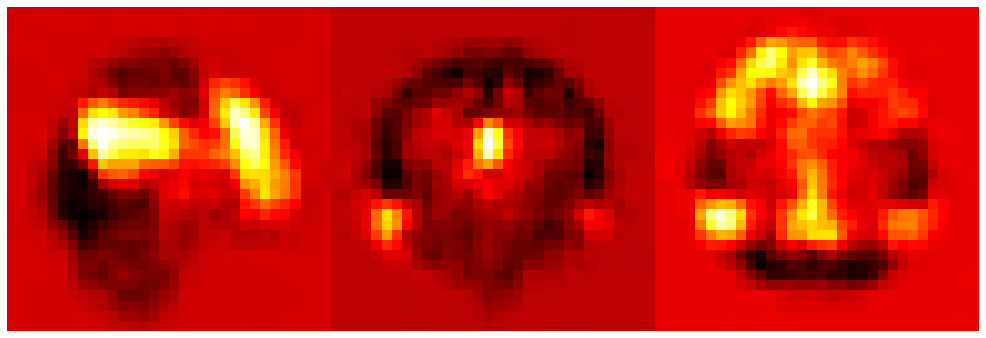

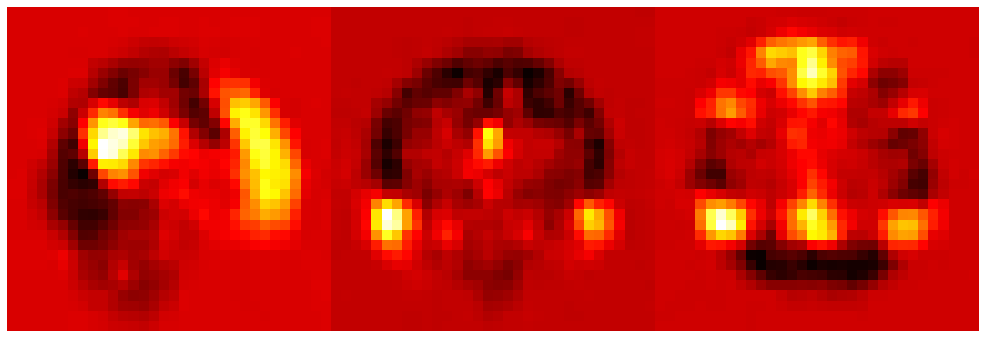

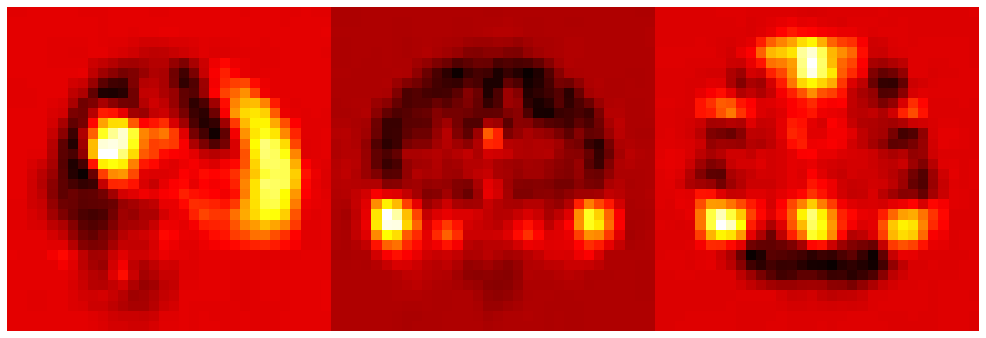

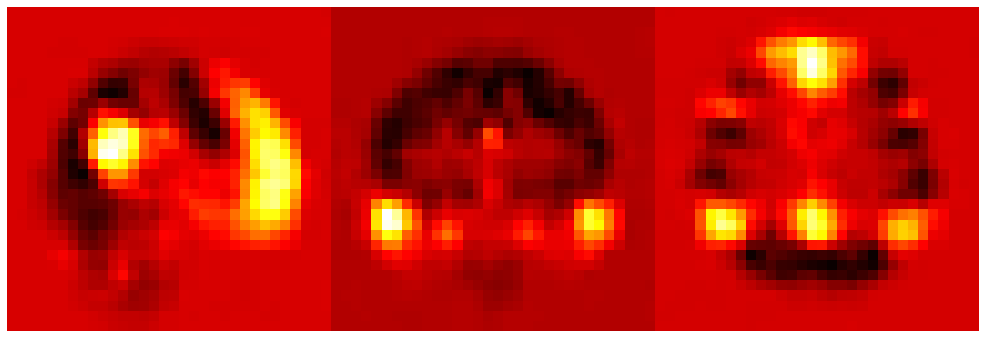

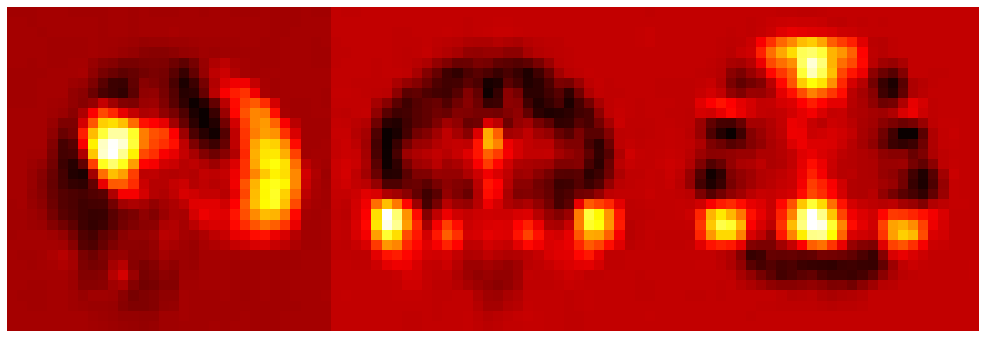

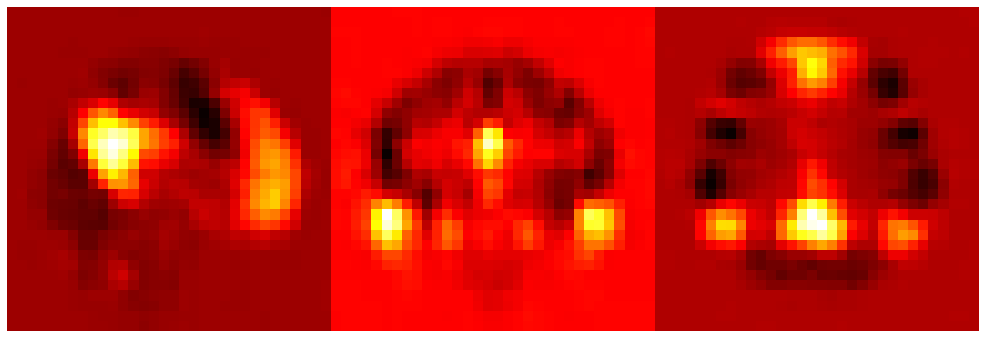

In [22]:
for i in range(51):
    ants.slice_image(im,axis=3,idx=i).plot_ortho(cmap='hot',flat=True,xyz_lines=False,orient_labels=False,figsize=2.0)